In [31]:
## Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout, GRU, Bidirectional

import yfinance as yf
import seaborn as sns
import math



## Load data

In [2]:
msft_ticker = yf.Ticker("MSFT")
msft_data = msft_ticker.history(start="2000-01-01", end="2023-11-05", interval="1d")


In [3]:
msft_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,36.457984,36.846248,34.788449,36.205612,53228400,0.0,0.0
2000-01-04 00:00:00-05:00,35.273772,36.380324,34.866095,34.982574,54119000,0.0,0.0
2000-01-05 00:00:00-05:00,34.516662,36.147370,33.973092,35.351429,64059600,0.0,0.0
2000-01-06 00:00:00-05:00,34.846687,35.370843,33.662482,34.167225,54976600,0.0,0.0
2000-01-07 00:00:00-05:00,33.740119,34.866084,33.332442,34.613712,62013600,0.0,0.0


In [4]:
# check null
msft_data.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

In [71]:
msft_data.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5999.000000,5999.000000,5999.000000,5999.000000,5.999000e+03,5999.000000,5999.000000
mean,70.269762,70.999662,69.526129,70.286945,5.137814e+07,0.004432,0.000333
std,87.598423,88.504588,86.658379,87.619441,3.076160e+07,0.056597,0.025822
min,11.364952,11.678984,11.118213,11.327567,7.425600e+06,0.000000,0.000000
25%,19.032043,19.240168,18.869620,19.058251,2.875525e+07,0.000000,0.000000
50%,23.654439,23.861629,23.420220,23.640194,4.612340e+07,0.000000,0.000000
75%,78.026054,78.478431,77.442796,78.063660,6.507830e+07,0.000000,0.000000
max,360.985725,366.005075,351.695397,358.730469,5.910522e+08,3.080000,2.000000


## Data Visualization

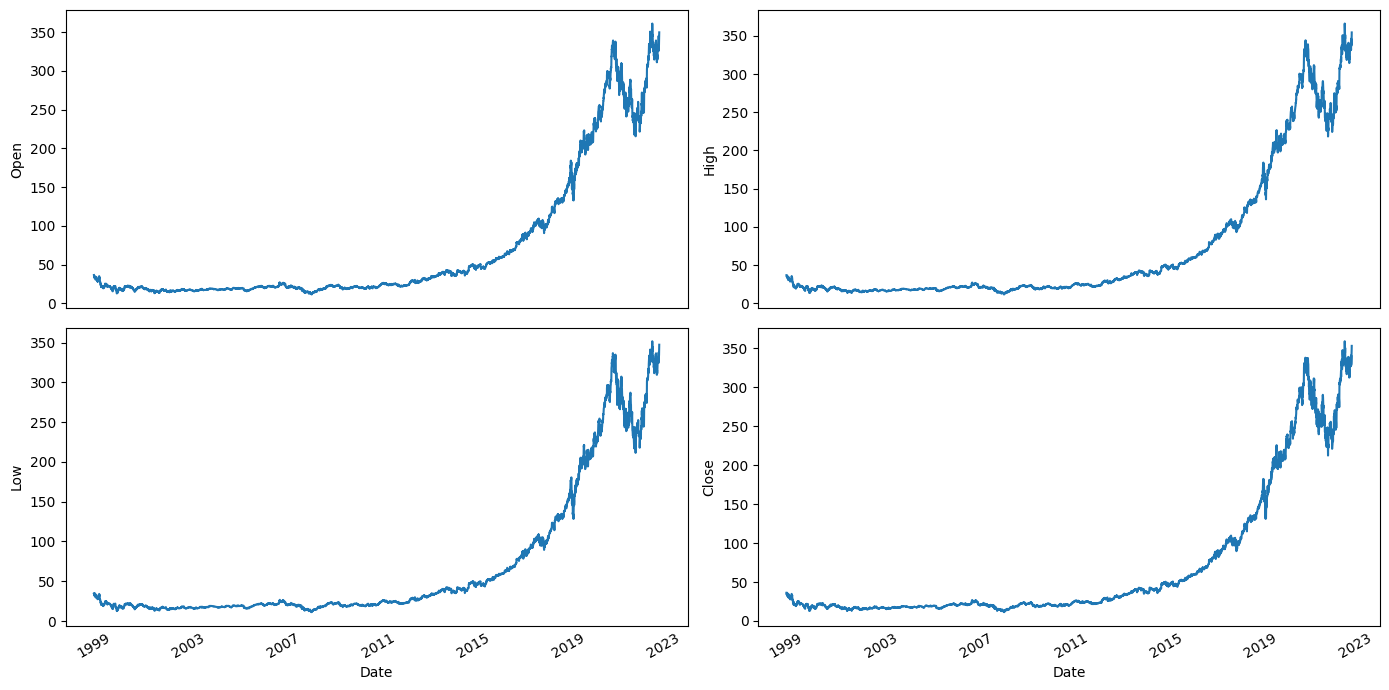

In [5]:
# Plot line charts
df_plot = msft_data[['Open','High','Low','Close']].copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

In [117]:
msft_close = msft_data[['Close']].copy()

scaler = MinMaxScaler()
msft_close_scaled = pd.DataFrame(scaler.fit_transform(msft_close)).rename(columns={0:"Close"})

msft_close_scaled.index = msft_close.index


In [118]:
# msft_close_scaled.head()
msft_close_scaled.head()

,Close
Date,
2000-01-03 00:00:00-05:00,0.071612
2000-01-04 00:00:00-05:00,0.068091
2000-01-05 00:00:00-05:00,0.069153
2000-01-06 00:00:00-05:00,0.065744
2000-01-07 00:00:00-05:00,0.067029


In [341]:

training_size = round((msft_close_scaled.shape[0]*0.1)*6)
validation_size = round((msft_close_scaled.shape[0]*0.1)*8)
test_size = round((msft_close_scaled.shape[0]))
print(training_size,validation_size-training_size,test_size-validation_size)

3599 1200 1200


Split Data

In [342]:
data_training = msft_close_scaled[:training_size]
data_validation = msft_close_scaled[training_size:validation_size]
data_test = msft_close_scaled[validation_size:test_size]

In [343]:
print(data_training.shape[0], data_validation.shape[0], data_test.shape[0])

3599 1200 1200


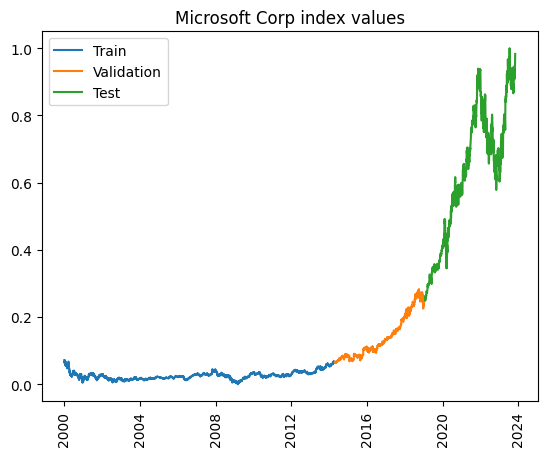

In [344]:
plt.plot(data_training.index, data_training)
plt.plot(data_validation.index, data_validation)
plt.plot(data_test.index, data_test)
plt.title("Microsoft Corp index values")
plt.xticks(rotation=90)
plt.legend(['Train', 'Validation', 'Test'])

In [345]:
TIME_STEP = 20
def create_sequence(data, time_step):

    sliding_data = []

    for index in range(len(data) - time_step):
        sliding_data.append(data[index: index + time_step])

    sliding_data = np.array(sliding_data)

    x_data = sliding_data.reshape(-1,time_step, 1)
    y_data = np.array(data[time_step:]).reshape(-1,1)

    return x_data, y_data

In [346]:
X_train, y_train = create_sequence(data_training, TIME_STEP)
X_val, y_val = create_sequence(data_validation, TIME_STEP)
X_test, y_test = create_sequence(data_test, TIME_STEP)

In [471]:
def plot_training_history(fitted_model):
    epochs = len(fitted_model.history['loss'])
    plt.plot(range(1,epochs+1), fitted_model.history['loss'], 'g', range(1,epochs+1), fitted_model.history['val_loss'], 'r')
    plt.legend(['training loss','validation loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()

def plot_result(y_train, y_test, train_predict, test_predict, offset):
    
    figure, axes = plt.subplots(figsize=(15, 6))
    actual = np.append(y_train, y_test)
    predictions = np.append(train_predict, test_predict)
    axes.plot(msft_close[offset:validation_size-offset].index, actual, color = 'red', label = 'Real Microsoft Corp Index Price ')
    axes.plot(msft_close[offset:validation_size-offset].index, predictions, color = 'blue', label = 'Predicted Microsoft Corp Index Price ')   
    plt.axvline(x = msft_close.index[training_size+offset], color = 'g', label = 'training data cutoff')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Days')
    plt.ylabel('Stock price')
    plt.title('Actual and Predicted Values')
    plt.show()

def plot_test_result(y_test, test_predict, offset):
    figure, axes = plt.subplots(figsize=(15, 6))
    axes.plot(msft_close[validation_size+offset:].index, y_test, color = 'red', label = 'Real Microsoft Corp Index Price ')
    axes.plot(msft_close[validation_size+offset:].index, test_predict, color = 'blue', label = 'Predicted Microsoft Corp Index Price ')   
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Days')
    plt.ylabel('Stock price')
    plt.title('Actual and Predicted Values')
    plt.show()    

def print_error(y, predict, name):
    
    # Unscale the predicted values
    y_pred = scaler.inverse_transform(predict)
    y_unscaled = scaler.inverse_transform(y.reshape(-1, 1))
    
    # Root mean squared error (RMSE)
    RMSE = mean_squared_error(y_unscaled, y_pred, squared=False)
    print(f'{name} root mean squared error (RMSE): {np.round(RMSE, 3)}')
    return y_unscaled, y_pred
          


In [26]:
EPOCHS_NUM = 50
BATCH_SIZE = 32

###  Vanilla RNN

In [101]:
def vanilla_RNN(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(units=hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model


In [348]:
n_hidden_units = 64
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [349]:
# Create vanilla RNN model
vanilla_rnn = vanilla_RNN(n_hidden_units, n_dense_units, input_shape, activation='tanh')

# Training the vanilla RNN

fitted_vanilla_rnn = vanilla_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
112/112 [==============================] - 4s 12ms/step - loss: 7.0200e-05 - val_loss: 3.5166e-04
Epoch 2/50
112/112 [==============================] - 1s 8ms/step - loss: 6.5252e-06 - val_loss: 7.4152e-05
Epoch 3/50
112/112 [==============================] - 1s 8ms/step - loss: 5.0786e-06 - val_loss: 1.2422e-04
Epoch 4/50
112/112 [==============================] - 1s 8ms/step - loss: 4.2529e-06 - val_loss: 4.2172e-05
Epoch 5/50
112/112 [==============================] - 1s 8ms/step - loss: 4.1145e-06 - val_loss: 4.1157e-05
Epoch 6/50
112/112 [==============================] - 1s 8ms/step - loss: 3.6016e-06 - val_loss: 2.3068e-05
Epoch 7/50
112/112 [==============================] - 1s 8ms/step - loss: 3.1148e-06 - val_loss: 1.9857e-05
Epoch 8/50
112/112 [==============================] - 1s 8ms/step - loss: 3.0146e-06 - val_loss: 2.5898e-05
Epoch 9/50
112/112 [==============================] - 1s 12ms/step - loss: 2.9644e-06 - val_loss: 2.0132e-05
Epoch 10/50
112/112 [=====

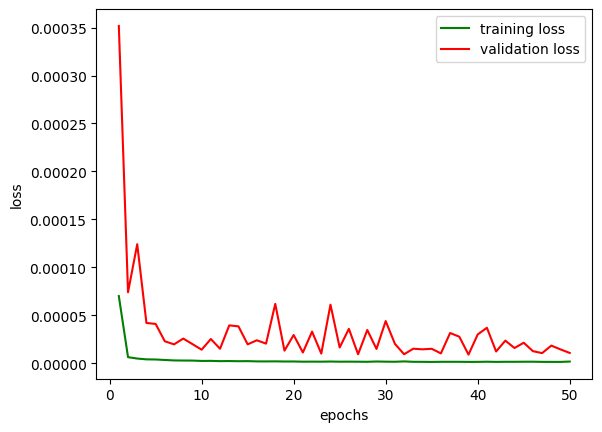

In [350]:
plot_training_history(fitted_vanilla_rnn)

In [351]:
train_predict_vanilla = fitted_vanilla_rnn.model.predict(X_train)
val_predict_vanilla = fitted_vanilla_rnn.model.predict(X_val)


37/37 [==============================] - 0s 5ms/step


In [352]:
y_train_unscaled, train_predict_vanilla_unscaled = print_error(y_train,train_predict_vanilla,'Train')
y_val_unscaled, val_predict_vanilla_unscaled = print_error(y_val,val_predict_vanilla,'Validation')

Train root mean squared error (RMSE): 0.449
Validation root mean squared error (RMSE): 1.148


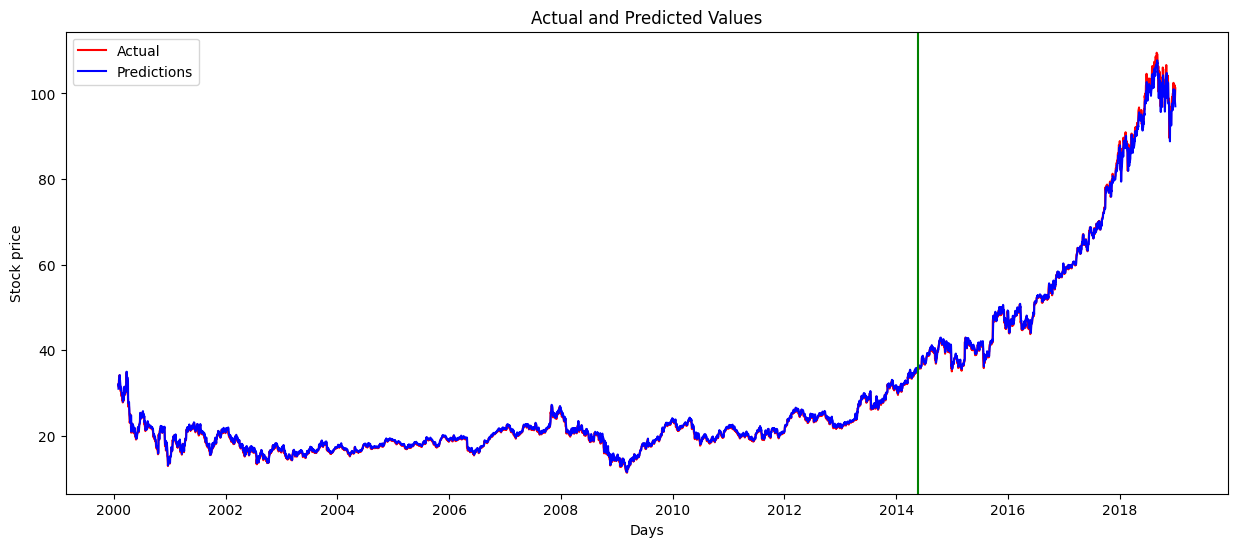

In [357]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_vanilla_unscaled, val_predict_vanilla_unscaled, TIME_STEP)

### Add more layers

In [157]:
# Creating RNN with multiple layers
def RNN_1(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(SimpleRNN(hidden_units_list[0], input_shape=input_shape,activation=activation, return_sequences=True))
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(SimpleRNN(hidden_units_list[i], activation=activation,
                      return_sequences=False))
        else:
            model.add(SimpleRNN(hidden_units_list[i], activation=activation,
                      return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

In [464]:
n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [465]:
rnn_1 = RNN_1(n_hidden_units_list, n_dense_units,input_shape, activation='tanh')

fitted_rnn_1 = rnn_1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
112/112 [==============================] - 8s 29ms/step - loss: 0.0074 - val_loss: 0.0034
Epoch 2/50
112/112 [==============================] - 2s 18ms/step - loss: 1.6682e-05 - val_loss: 0.0026
Epoch 3/50
112/112 [==============================] - 2s 18ms/step - loss: 1.1506e-05 - val_loss: 0.0019
Epoch 4/50
112/112 [==============================] - 2s 18ms/step - loss: 8.9330e-06 - val_loss: 0.0019
Epoch 5/50
112/112 [==============================] - 2s 21ms/step - loss: 7.0738e-06 - val_loss: 0.0017
Epoch 6/50
112/112 [==============================] - 2s 19ms/step - loss: 6.7916e-06 - val_loss: 0.0018
Epoch 7/50
112/112 [==============================] - 2s 18ms/step - loss: 6.6511e-06 - val_loss: 0.0017
Epoch 8/50
112/112 [==============================] - 2s 22ms/step - loss: 6.3849e-06 - val_loss: 0.0015
Epoch 9/50
112/112 [==============================] - 2s 18ms/step - loss: 5.8357e-06 - val_loss: 0.0012
Epoch 10/50
112/112 [==============================] - 2s 1

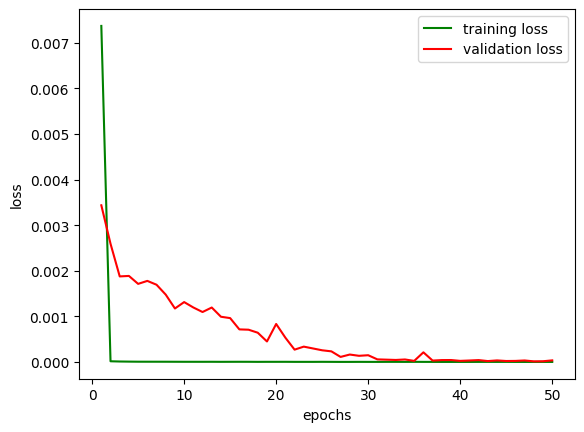

In [466]:
plot_training_history(fitted_rnn_1)

In [467]:
train_predict_rnn1 = fitted_rnn_1.model.predict(X_train)
val_predict_rnn1 = fitted_rnn_1.model.predict(X_val)


37/37 [==============================] - 0s 9ms/step


In [468]:
y_train_unscaled, train_predict_rnn1_unscaled = print_error(y_train,train_predict_rnn1,'Train')
y_val_unscaled, val_predict_rnn1_unscaled = print_error(y_val,val_predict_rnn1,'Validation')

Train root mean squared error (RMSE): 0.598
Validation root mean squared error (RMSE): 2.09


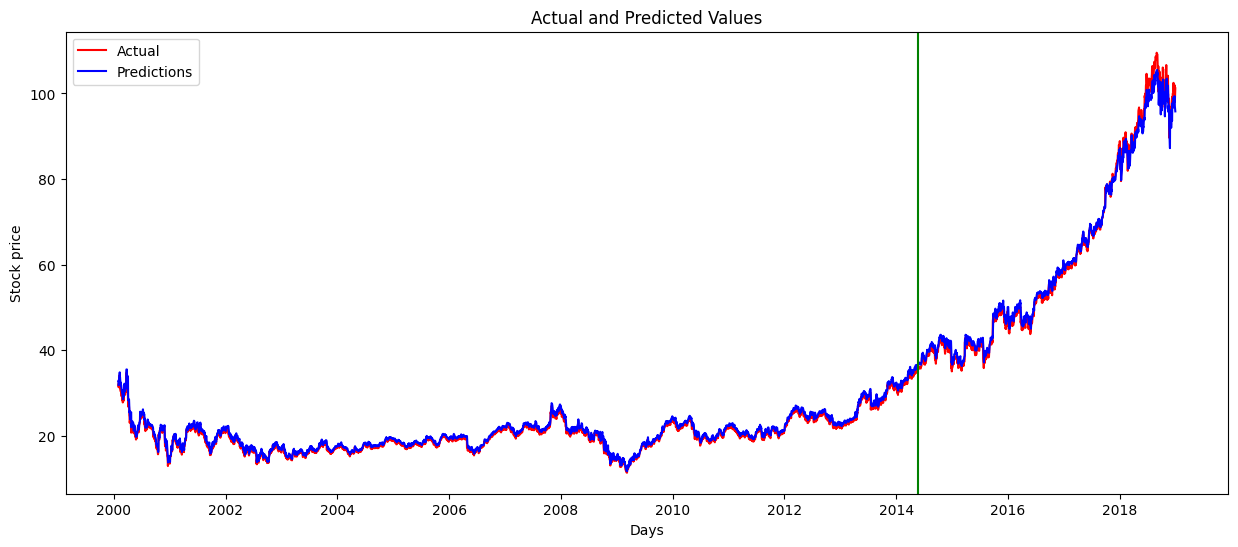

In [369]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_rnn1_unscaled, val_predict_rnn1_unscaled,TIME_STEP)

### Optimizers and learning rate scheduling

In [370]:
# experiment with optimizer and learning rate.
def RNN_2(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = None
    if optimizer == "Adam":
        optimizing_function = keras.optimizers.Adam()
    elif optimizer == "RMSprop":
        optimizing_function = keras.optimizers.RMSprop()
    elif optimizer == "SGD":   
        optimizing_function = keras.optimizers.SGD() 

    model.compile(loss='mean_squared_error',optimizer=optimizing_function)
    return model


initial_learning_rate = 0.01
time_decay = initial_learning_rate / EPOCHS_NUM

# Step decay for learning rate
def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 10.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# Exponential decay for learning rate
def exp_decay(epoch, lr):
    k = 0.1
    return initial_learning_rate * math.exp(-k*epoch)


callbacks_decay = [keras.callbacks.LearningRateScheduler(step_decay, verbose=1),
    keras.callbacks.LearningRateScheduler(exp_decay, verbose=1)]
callback_decay_keys = ["constant", "step_decay", "exp_decay"]

In [371]:
'''
Running the vanilla RNN model with RMSProp,Adam, SGD and 3 different types of learning rate
scheduling.
'''
n_hidden_units = 64
n_dense_units = 1
results_rnn = []

optimizers = ["Adam", "RMSprop", "SGD"]

for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        
        model = RNN_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer=optimizer)
        
        fitted_model = None
        
        if i == 0:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)
        else:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                     batch_size=BATCH_SIZE, epochs=EPOCHS_NUM, callbacks=[callbacks_decay[i - 1]])

        predict = fitted_model.model.predict(X_val)
        y_pred = scaler.inverse_transform(predict)
        y_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1))
        val_rmse = mean_squared_error(y_unscaled, y_pred, squared=False)

        results_rnn.append((optimizer, callback_decay_keys[i], val_rmse))


Epoch 1/50
112/112 [==============================] - 4s 11ms/step - loss: 4.1712e-05 - val_loss: 8.2530e-05
Epoch 2/50
112/112 [==============================] - 1s 8ms/step - loss: 3.6206e-06 - val_loss: 8.9630e-05
Epoch 3/50
112/112 [==============================] - 1s 8ms/step - loss: 3.1031e-06 - val_loss: 4.1212e-05
Epoch 4/50
112/112 [==============================] - 1s 10ms/step - loss: 2.5380e-06 - val_loss: 7.8036e-05
Epoch 5/50
112/112 [==============================] - 1s 10ms/step - loss: 2.4269e-06 - val_loss: 7.7916e-05
Epoch 6/50
112/112 [==============================] - 2s 14ms/step - loss: 2.3199e-06 - val_loss: 5.7192e-05
Epoch 7/50
112/112 [==============================] - 1s 10ms/step - loss: 2.2299e-06 - val_loss: 6.5143e-05
Epoch 8/50
112/112 [==============================] - 2s 15ms/step - loss: 1.9513e-06 - val_loss: 1.3692e-05
Epoch 9/50
112/112 [==============================] - 1s 7ms/step - loss: 1.9980e-06 - val_loss: 1.8070e-05
Epoch 10/50
112/112 [=

In [372]:
pd.DataFrame(results_rnn, columns=[
                  "Optimizer", "Decay type", "Val RMSE"])

,Optimizer,Decay type,Val RMSE
0,Adam,constant,1.743248
1,Adam,step_decay,1.096546
2,Adam,exp_decay,23.451884
3,RMSprop,constant,3.803932
4,RMSprop,step_decay,40.409846
5,RMSprop,exp_decay,11.008621
6,SGD,constant,14.687644
7,SGD,step_decay,17.729638
8,SGD,exp_decay,15.940338


In [373]:
input_shape = (TIME_STEP, 1)
optimized_rnn = RNN_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")


fitted_optimized_rnn = optimized_rnn.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM, callbacks=[keras.callbacks.LearningRateScheduler(step_decay, verbose=1)])



Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
112/112 [==============================] - 4s 13ms/step - loss: 0.0025 - val_loss: 3.5359e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
112/112 [==============================] - 1s 10ms/step - loss: 1.4505e-05 - val_loss: 2.2175e-04 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
112/112 [==============================] - 1s 8ms/step - loss: 9.2401e-06 - val_loss: 1.0610e-04 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
112/112 [==============================] - 1s 8ms/step - loss: 6.4244e-06 - val_loss: 7.4700e-05 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/50
112/112 [==============================] - 1s 8ms/step - loss: 3.9499e-06 - val_loss: 1.4334e-05 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/50
112/112 

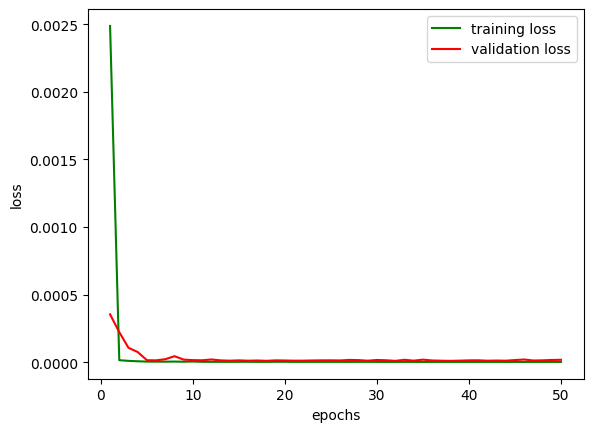

In [374]:
plot_training_history(fitted_optimized_rnn)

In [375]:
train_predict_optimized_rnn = fitted_optimized_rnn.model.predict(X_train)
val_predict_optimized_rnn = fitted_optimized_rnn.model.predict(X_val)


y_train_unscaled, train_predict_optimized_rnn_unscaled = print_error(y_train,train_predict_optimized_rnn,'Train')
y_val_unscaled, val_predict_optimized_rnn_unscaled = print_error(y_val,val_predict_optimized_rnn,'Validation')

37/37 [==============================] - 0s 4ms/step
Train root mean squared error (RMSE): 0.744
Validation root mean squared error (RMSE): 1.446


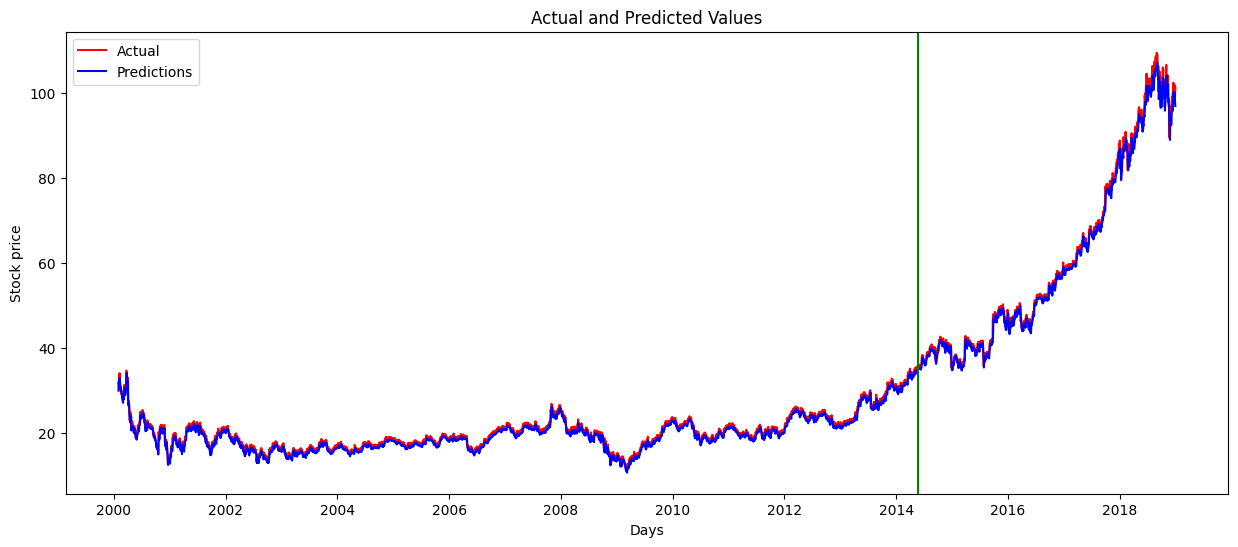

In [376]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_optimized_rnn_unscaled, val_predict_optimized_rnn_unscaled, TIME_STEP)

### Experiment with Window Size 10, 50

In [377]:
TIME_STEP_10 = 10
X_train_10, y_train_10 = create_sequence(data_training, TIME_STEP_10)
X_val_10, y_val_10 = create_sequence(data_validation, TIME_STEP_10)
X_test_10, y_test_10 = create_sequence(data_test, TIME_STEP_10)  

In [378]:
input_shape = (TIME_STEP_10, 1)
optimized_rnn_10 = RNN_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")

fitted_optimized_rnn_10 = optimized_rnn.fit(X_train_10, y_train_10, validation_data=(X_val_10, y_val_10), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
113/113 [==============================] - 4s 15ms/step - loss: 2.5063e-05 - val_loss: 2.2264e-05
Epoch 2/50
113/113 [==============================] - 1s 8ms/step - loss: 1.8394e-06 - val_loss: 2.6158e-05
Epoch 3/50
113/113 [==============================] - 1s 7ms/step - loss: 1.7624e-06 - val_loss: 2.5462e-05
Epoch 4/50
113/113 [==============================] - 1s 8ms/step - loss: 1.9092e-06 - val_loss: 2.5312e-05
Epoch 5/50
113/113 [==============================] - 1s 12ms/step - loss: 1.7785e-06 - val_loss: 2.0753e-05
Epoch 6/50
113/113 [==============================] - 1s 10ms/step - loss: 1.5979e-06 - val_loss: 3.5847e-05
Epoch 7/50
113/113 [==============================] - 1s 7ms/step - loss: 1.6564e-06 - val_loss: 3.5881e-05
Epoch 8/50
113/113 [==============================] - 1s 7ms/step - loss: 1.6318e-06 - val_loss: 1.7680e-05
Epoch 9/50
113/113 [==============================] - 1s 6ms/step - loss: 1.6223e-06 - val_loss: 2.5107e-05
Epoch 10/50
113/113 [====

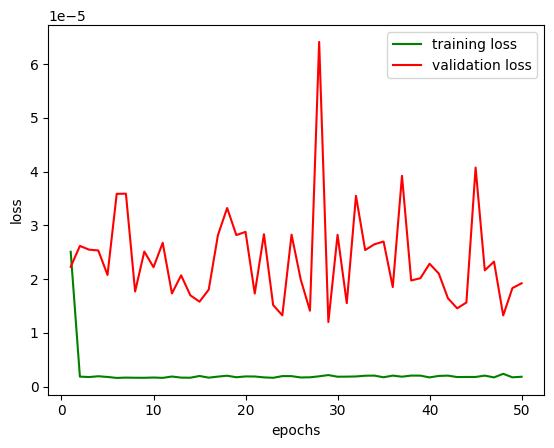

In [379]:
plot_training_history(fitted_optimized_rnn_10)

In [380]:
train_predict_optimized_rnn_10 = fitted_optimized_rnn_10.model.predict(X_train_10)
val_predict_optimized_rnn_10 = fitted_optimized_rnn_10.model.predict(X_val_10)

y_train_unscaled_10, train_predict_optimized_rnn_10_unscaled = print_error(y_train_10,train_predict_optimized_rnn_10,'Train')
y_val_unscaled_10, val_predict_optimized_rnn_10_unscaled = print_error(y_val_10,val_predict_optimized_rnn_10,'Validation')

38/38 [==============================] - 0s 6ms/step
Train root mean squared error (RMSE): 0.515
Validation root mean squared error (RMSE): 1.523


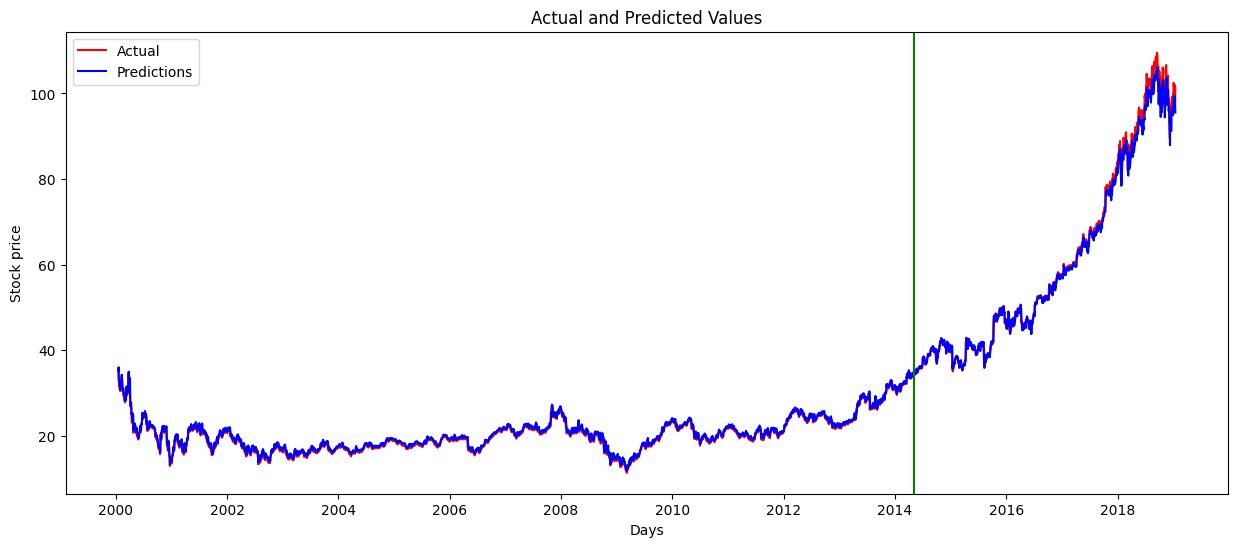

In [381]:
plot_result(y_train_unscaled_10, y_val_unscaled_10, train_predict_optimized_rnn_10_unscaled, val_predict_optimized_rnn_10_unscaled, TIME_STEP_10)

In [382]:
TIME_STEP_50 = 50
X_train_50, y_train_50 = create_sequence(data_training, TIME_STEP_50)
X_val_50, y_val_50 = create_sequence(data_validation, TIME_STEP_50)
X_test_50, y_test_50 = create_sequence(data_test, TIME_STEP_50)  

In [383]:
input_shape = (TIME_STEP_50, 1)
optimized_rnn_50 = RNN_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")

fitted_optimized_rnn_50 = optimized_rnn.fit(X_train_50, y_train_50, validation_data=(X_val_50, y_val_50), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
111/111 [==============================] - 2s 15ms/step - loss: 3.1217e-06 - val_loss: 3.5784e-05
Epoch 2/50
111/111 [==============================] - 2s 16ms/step - loss: 1.4568e-06 - val_loss: 1.3592e-05
Epoch 3/50
111/111 [==============================] - 1s 13ms/step - loss: 1.5463e-06 - val_loss: 2.7952e-05
Epoch 4/50
111/111 [==============================] - 2s 15ms/step - loss: 1.6789e-06 - val_loss: 1.3908e-05
Epoch 5/50
111/111 [==============================] - 2s 17ms/step - loss: 1.8443e-06 - val_loss: 2.5961e-05
Epoch 6/50
111/111 [==============================] - 3s 28ms/step - loss: 1.4957e-06 - val_loss: 1.3532e-05
Epoch 7/50
111/111 [==============================] - 1s 13ms/step - loss: 1.5000e-06 - val_loss: 3.3230e-05
Epoch 8/50
111/111 [==============================] - 1s 12ms/step - loss: 1.5544e-06 - val_loss: 1.2798e-05
Epoch 9/50
111/111 [==============================] - 1s 13ms/step - loss: 1.7877e-06 - val_loss: 1.0793e-05
Epoch 10/50
111/111

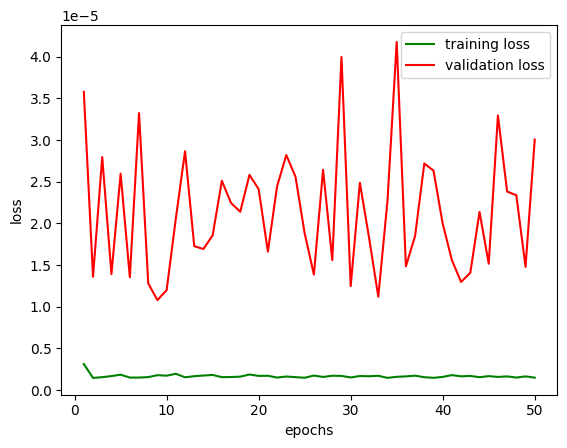

In [384]:
plot_training_history(fitted_optimized_rnn_50)

In [385]:
train_predict_optimized_rnn_50 = fitted_optimized_rnn_50.model.predict(X_train_50)
val_predict_optimized_rnn_50 = fitted_optimized_rnn_50.model.predict(X_val_50)

y_train_unscaled_50, train_predict_optimized_rnn_50_unscaled = print_error(y_train_50,train_predict_optimized_rnn_50,'Train')
y_val_unscaled_50, val_predict_optimized_rnn_50_unscaled = print_error(y_val_50,val_predict_optimized_rnn_50,'Validation')

36/36 [==============================] - 0s 6ms/step
Train root mean squared error (RMSE): 0.567
Validation root mean squared error (RMSE): 1.904


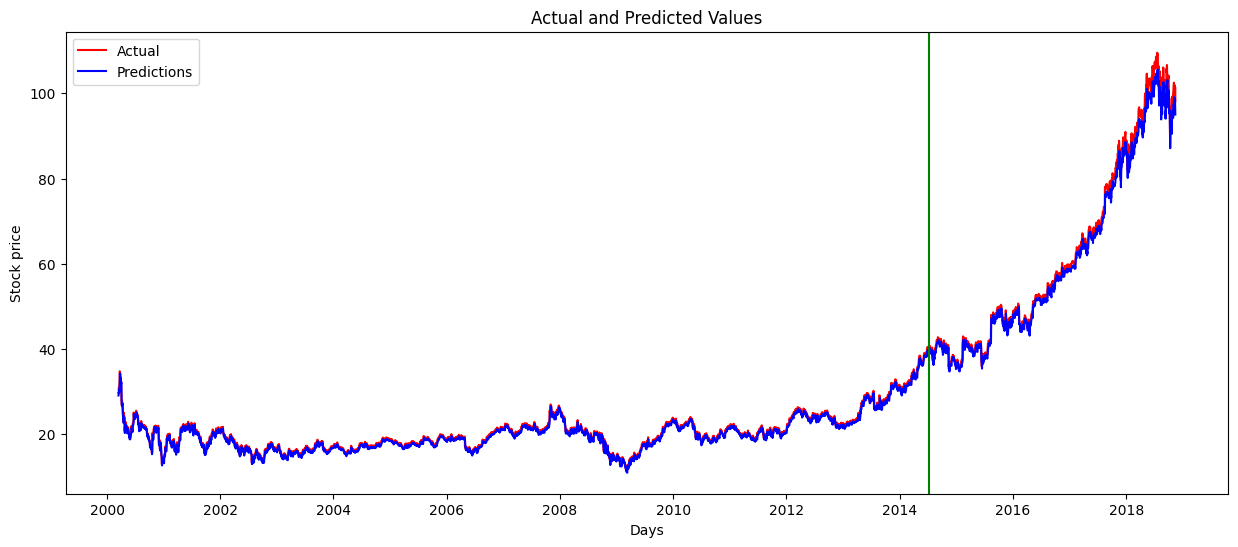

In [386]:
plot_result(y_train_unscaled_50, y_val_unscaled_50, train_predict_optimized_rnn_50_unscaled, val_predict_optimized_rnn_50_unscaled, TIME_STEP_50)

## LSTM

In [231]:
def vanilla_LSTM(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units, return_sequences=False, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error',optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model


In [388]:
n_hidden_units = 64
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [389]:

lstm_base = vanilla_LSTM(n_hidden_units, n_dense_units,input_shape, activation='tanh')

fitted_lstm_base = lstm_base.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)


Epoch 1/50
112/112 [==============================] - 13s 77ms/step - loss: 4.1392e-05 - val_loss: 3.3336e-05
Epoch 2/50
112/112 [==============================] - 2s 16ms/step - loss: 5.1832e-06 - val_loss: 2.6153e-05
Epoch 3/50
112/112 [==============================] - 2s 20ms/step - loss: 4.7430e-06 - val_loss: 5.4451e-05
Epoch 4/50
112/112 [==============================] - 2s 15ms/step - loss: 4.4895e-06 - val_loss: 2.0742e-05
Epoch 5/50
112/112 [==============================] - 3s 24ms/step - loss: 4.3766e-06 - val_loss: 2.9101e-05
Epoch 6/50
112/112 [==============================] - 2s 17ms/step - loss: 3.6215e-06 - val_loss: 1.9373e-05
Epoch 7/50
112/112 [==============================] - 2s 20ms/step - loss: 3.7108e-06 - val_loss: 2.7672e-05
Epoch 8/50
112/112 [==============================] - 3s 23ms/step - loss: 3.6901e-06 - val_loss: 5.0974e-05
Epoch 9/50
112/112 [==============================] - 2s 18ms/step - loss: 3.2383e-06 - val_loss: 3.2500e-05
Epoch 10/50
112/11

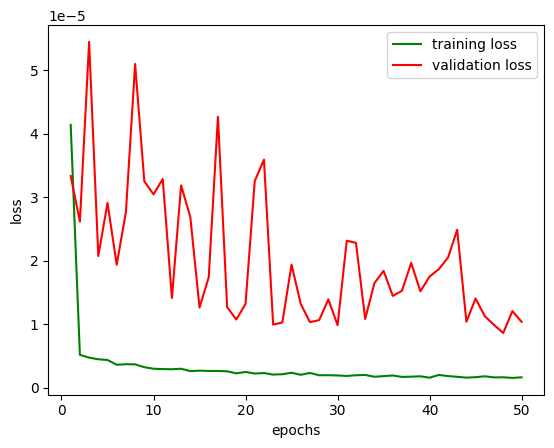

In [390]:
plot_training_history(fitted_lstm_base)


In [391]:
train_predict_lstm_base = fitted_lstm_base.model.predict(X_train)
val_predict_lstm_base = fitted_lstm_base.model.predict(X_val)

37/37 [==============================] - 0s 7ms/step


In [392]:
y_train_unscaled, train_predict_lstm_base = print_error(y_train,train_predict_lstm_base,'Train')
y_val_unscaled, val_predict_lstm_base_unscaled = print_error(y_val,val_predict_lstm_base,'Validation')

Train root mean squared error (RMSE): 0.437
Validation root mean squared error (RMSE): 1.119


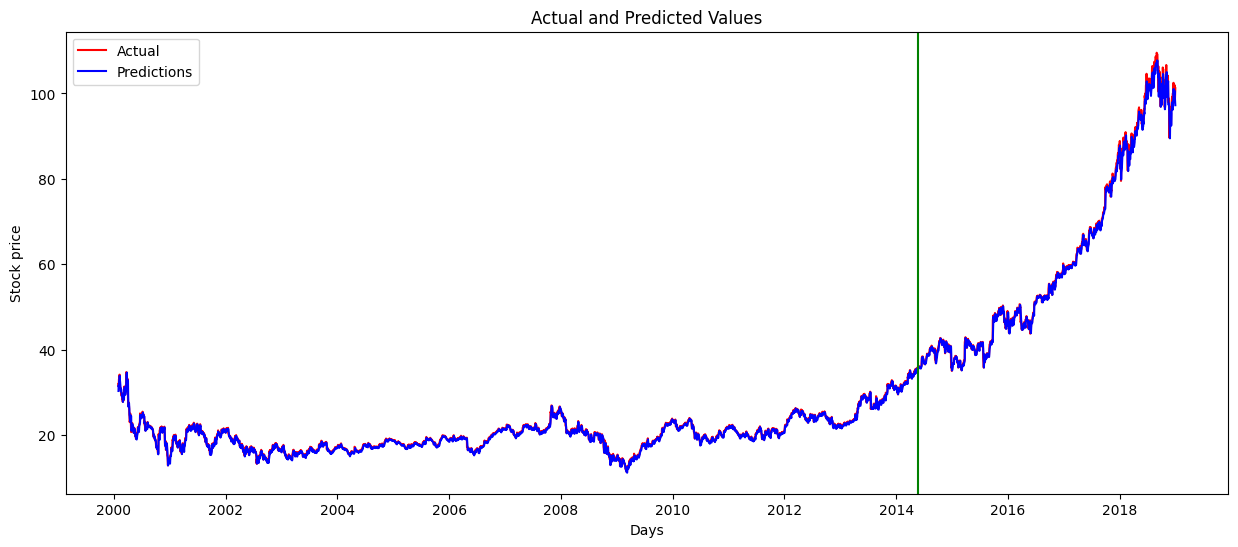

In [393]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_lstm_base, val_predict_lstm_base_unscaled,TIME_STEP)

### Add more layers

In [238]:
# Creating LSTM with multiple layers
def LSTM_1(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(LSTM(hidden_units_list[0], input_shape=input_shape,
                        activation=activation, return_sequences=True))
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(LSTM(hidden_units_list[i], activation=activation,
                      return_sequences=False))
        else:
            model.add(LSTM(hidden_units_list[i], activation=activation,
                      return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

In [239]:
n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [394]:
lstm_1 = LSTM_1(n_hidden_units_list, n_dense_units,input_shape, activation='tanh')

fitted_lstm_1 = lstm_1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
112/112 [==============================] - 20s 63ms/step - loss: 5.7257e-05 - val_loss: 1.3411e-04
Epoch 2/50
112/112 [==============================] - 5s 45ms/step - loss: 9.5364e-06 - val_loss: 9.6948e-05
Epoch 3/50
112/112 [==============================] - 6s 52ms/step - loss: 8.6850e-06 - val_loss: 7.5521e-05
Epoch 4/50
112/112 [==============================] - 6s 53ms/step - loss: 7.8727e-06 - val_loss: 9.4508e-05
Epoch 5/50
112/112 [==============================] - 5s 45ms/step - loss: 6.7834e-06 - val_loss: 8.5831e-05
Epoch 6/50
112/112 [==============================] - 4s 39ms/step - loss: 6.4892e-06 - val_loss: 2.3700e-05
Epoch 7/50
112/112 [==============================] - 4s 33ms/step - loss: 5.9620e-06 - val_loss: 3.4572e-05
Epoch 8/50
112/112 [==============================] - 4s 37ms/step - loss: 5.3288e-06 - val_loss: 2.1692e-05
Epoch 9/50
112/112 [==============================] - 4s 33ms/step - loss: 5.8482e-06 - val_loss: 4.3366e-04
Epoch 10/50
112/11

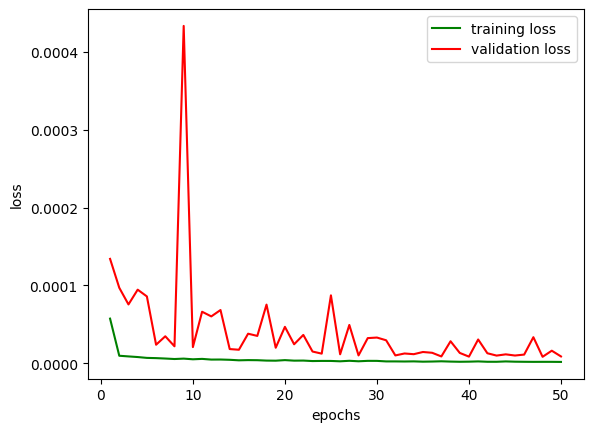

In [395]:
plot_training_history(fitted_lstm_1)

In [396]:
train_predict_lstm1 = fitted_lstm_1.model.predict(X_train)
val_predict_lstm1 = fitted_lstm_1.model.predict(X_val)

37/37 [==============================] - 1s 15ms/step


In [397]:
y_train_unscaled, train_predict_lstm1_unscaled = print_error(y_train,train_predict_lstm1,'Train')
y_val_unscaled, val_predict_lstm1_unscaled = print_error(y_val,val_predict_lstm1,'Validation')

Train root mean squared error (RMSE): 0.464
Validation root mean squared error (RMSE): 1.022


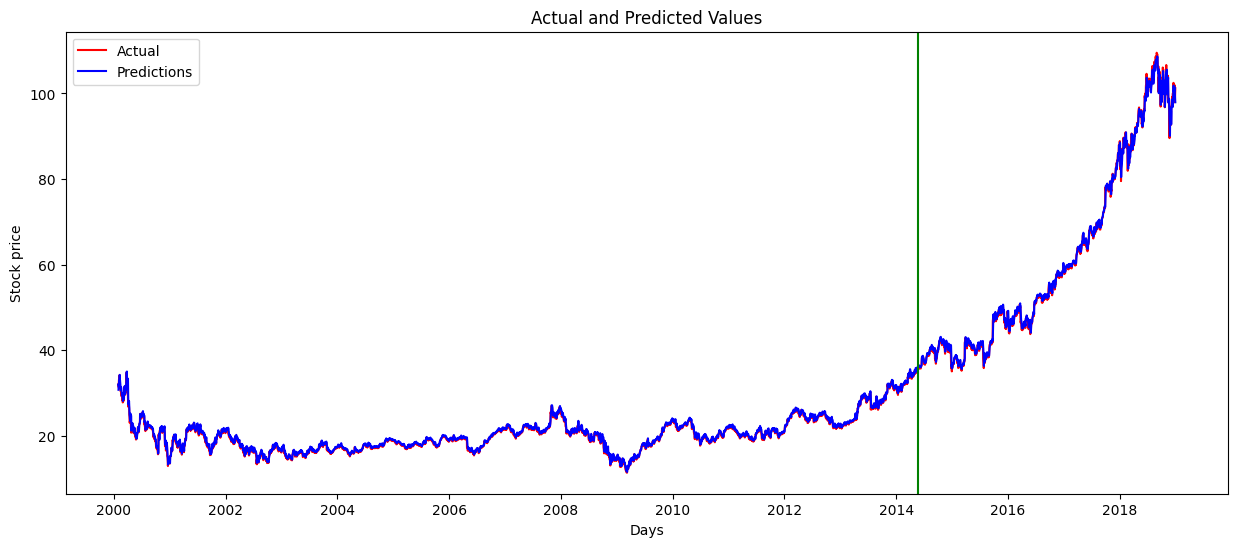

In [399]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_lstm1_unscaled, val_predict_lstm1_unscaled, TIME_STEP)


### Optimizers and learning rate scheduling

In [400]:
# experiment with optimizer and learning rate.
def LSTM_2(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=input_shape,
                        activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = None
    if optimizer == "Adam":
        optimizing_function = keras.optimizers.Adam()
    elif optimizer == "RMSprop":
        optimizing_function = keras.optimizers.RMSprop()
    elif optimizer == "SGD":   
        optimizing_function = keras.optimizers.SGD() 

    model.compile(loss='mean_squared_error',optimizer=optimizing_function)
    return model


In [401]:
'''
Running the vanilla LSTM model with RMSProp,Adam, SGD and 3 different types of learning rate
scheduling.
'''
n_hidden_units = 64
n_dense_units = 1
results_vanilla_lstm = []

optimizers = ["Adam", "RMSprop", "SGD"]

for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        
        model = LSTM_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer=optimizer)
        
        fitted_model = None
        
        if i == 0:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)
        else:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                     batch_size=BATCH_SIZE, epochs=EPOCHS_NUM, callbacks=[callbacks_decay[i - 1]])

        predict = fitted_model.model.predict(X_val)
        y_pred = scaler.inverse_transform(predict)
        y_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1))
        val_rmse = mean_squared_error(y_unscaled, y_pred, squared=False)

        results_vanilla_lstm.append((optimizer, callback_decay_keys[i], val_rmse))


Epoch 1/50
112/112 [==============================] - 6s 20ms/step - loss: 4.0553e-05 - val_loss: 2.2073e-05
Epoch 2/50
112/112 [==============================] - 2s 14ms/step - loss: 5.7657e-06 - val_loss: 8.6132e-05
Epoch 3/50
112/112 [==============================] - 2s 14ms/step - loss: 5.3739e-06 - val_loss: 8.3321e-05
Epoch 4/50
112/112 [==============================] - 2s 18ms/step - loss: 4.5812e-06 - val_loss: 6.4368e-05
Epoch 5/50
112/112 [==============================] - 2s 16ms/step - loss: 3.8342e-06 - val_loss: 2.0871e-05
Epoch 6/50
112/112 [==============================] - 2s 19ms/step - loss: 3.7194e-06 - val_loss: 2.0689e-05
Epoch 7/50
112/112 [==============================] - 2s 20ms/step - loss: 3.5290e-06 - val_loss: 5.7512e-05
Epoch 8/50
112/112 [==============================] - 2s 21ms/step - loss: 3.2892e-06 - val_loss: 1.6879e-05
Epoch 9/50
112/112 [==============================] - 1s 13ms/step - loss: 3.4161e-06 - val_loss: 1.4790e-05
Epoch 10/50
112/112

In [402]:
pd.DataFrame(results_vanilla_lstm, columns=["Optimizer", "Decay type", "Val RMSE"])

,Optimizer,Decay type,Val RMSE
0,Adam,constant,1.022199
1,Adam,step_decay,1.034936
2,Adam,exp_decay,1.127867
3,RMSprop,constant,2.072666
4,RMSprop,step_decay,4.389242
5,RMSprop,exp_decay,4.166109
6,SGD,constant,48.422641
7,SGD,step_decay,47.563776
8,SGD,exp_decay,47.942337


Choose the best

In [404]:
optimized_lstm = LSTM_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")

fitted_optimized_lstm = optimized_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, 
                                           epochs=EPOCHS_NUM)


Epoch 1/50
112/112 [==============================] - 11s 48ms/step - loss: 5.9654e-05 - val_loss: 6.0011e-05
Epoch 2/50
112/112 [==============================] - 2s 22ms/step - loss: 5.9498e-06 - val_loss: 3.7484e-05
Epoch 3/50
112/112 [==============================] - 3s 27ms/step - loss: 5.3446e-06 - val_loss: 4.4400e-05
Epoch 4/50
112/112 [==============================] - 2s 20ms/step - loss: 4.8474e-06 - val_loss: 2.5201e-05
Epoch 5/50
112/112 [==============================] - 2s 15ms/step - loss: 4.2372e-06 - val_loss: 1.6474e-05
Epoch 6/50
112/112 [==============================] - 2s 15ms/step - loss: 3.8160e-06 - val_loss: 1.7970e-05
Epoch 7/50
112/112 [==============================] - 2s 18ms/step - loss: 3.7999e-06 - val_loss: 1.9749e-05
Epoch 8/50
112/112 [==============================] - 2s 15ms/step - loss: 3.4545e-06 - val_loss: 3.1841e-05
Epoch 9/50
112/112 [==============================] - 2s 15ms/step - loss: 3.2787e-06 - val_loss: 3.4041e-05
Epoch 10/50
112/11

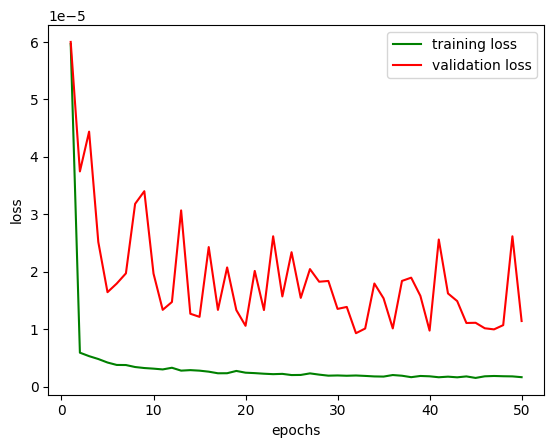

In [405]:
plot_training_history(fitted_optimized_lstm)

In [406]:
train_predict_optimized_lstm = fitted_optimized_lstm.model.predict(X_train)
val_predict_optimized_lstm = fitted_optimized_lstm.model.predict(X_val)


37/37 [==============================] - 0s 7ms/step


In [407]:
y_train_unscaled, train_predict_optimized_lstm_unscaled = print_error(y_train,train_predict_optimized_lstm,'Train')
y_val_unscaled, val_predict_optimized_lstm_unscaled = print_error(y_val,val_predict_optimized_lstm,'Validation')


Train root mean squared error (RMSE): 0.455
Validation root mean squared error (RMSE): 1.176


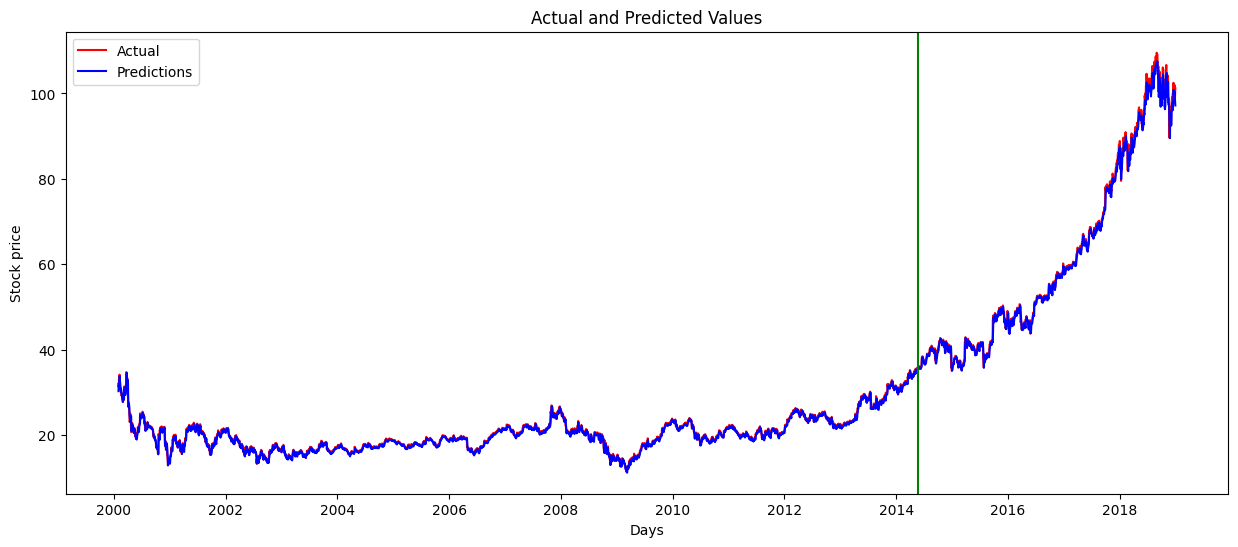

In [409]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_optimized_lstm_unscaled, 
            val_predict_optimized_lstm_unscaled, TIME_STEP)

### Experiment with Window Size 10, 50

In [410]:
input_shape = (TIME_STEP_10, 1)
optimized_lstm_10 = RNN_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")

fitted_optimized_lstm_10 = optimized_lstm_10.fit(X_train_10, y_train_10, validation_data=(X_val_10, y_val_10), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
113/113 [==============================] - 4s 10ms/step - loss: 5.1028e-05 - val_loss: 2.3326e-04
Epoch 2/50
113/113 [==============================] - 1s 7ms/step - loss: 5.8408e-06 - val_loss: 1.4097e-04
Epoch 3/50
113/113 [==============================] - 1s 6ms/step - loss: 4.3996e-06 - val_loss: 8.0519e-05
Epoch 4/50
113/113 [==============================] - 1s 6ms/step - loss: 3.9636e-06 - val_loss: 3.9881e-05
Epoch 5/50
113/113 [==============================] - 1s 7ms/step - loss: 3.8430e-06 - val_loss: 2.1456e-04
Epoch 6/50
113/113 [==============================] - 1s 8ms/step - loss: 3.3232e-06 - val_loss: 6.5130e-05
Epoch 7/50
113/113 [==============================] - 1s 9ms/step - loss: 3.0808e-06 - val_loss: 4.4813e-05
Epoch 8/50
113/113 [==============================] - 1s 8ms/step - loss: 2.8824e-06 - val_loss: 3.0862e-05
Epoch 9/50
113/113 [==============================] - 1s 11ms/step - loss: 2.9760e-06 - val_loss: 6.4032e-05
Epoch 10/50
113/113 [=====

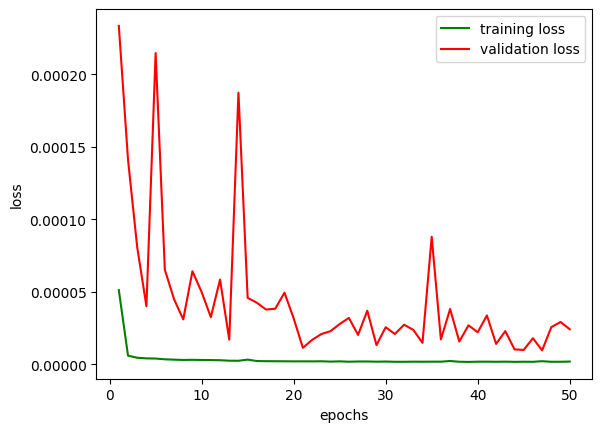

In [411]:
plot_training_history(fitted_optimized_lstm_10)

In [412]:
train_predict_optimized_lstm_10 = fitted_optimized_lstm_10.model.predict(X_train_10)
val_predict_optimized_lstm_10 = fitted_optimized_lstm_10.model.predict(X_val_10)

y_train_unscaled_10, train_predict_optimized_lstm_10_unscaled = print_error(y_train_10,train_predict_optimized_lstm_10,'Train')
y_val_unscaled_10, val_predict_optimized_lstm_10_unscaled = print_error(y_val_10,val_predict_optimized_lstm_10,'Validation')

38/38 [==============================] - 0s 3ms/step
Train root mean squared error (RMSE): 0.41
Validation root mean squared error (RMSE): 1.704


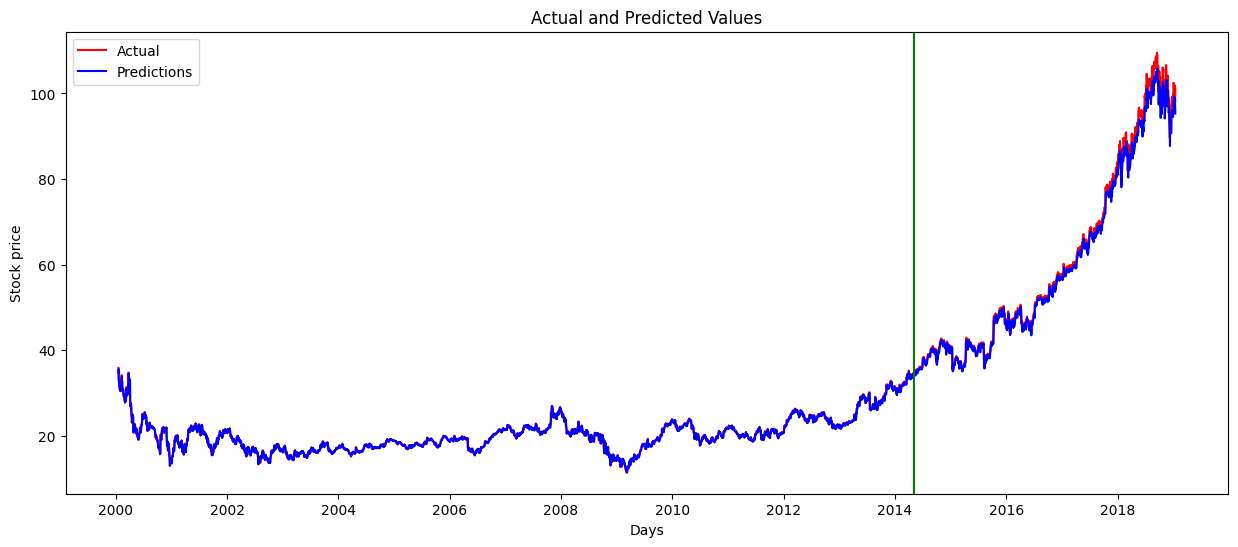

In [413]:
plot_result(y_train_unscaled_10, y_val_unscaled_10, train_predict_optimized_lstm_10_unscaled, val_predict_optimized_lstm_10_unscaled, TIME_STEP_10)

In [414]:
input_shape = (TIME_STEP_50, 1)
optimized_lstm_50 = RNN_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")

fitted_optimized_lstm_50 = optimized_lstm_50.fit(X_train_50, y_train_50, validation_data=(X_val_50, y_val_50), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
111/111 [==============================] - 4s 18ms/step - loss: 3.2119e-05 - val_loss: 2.0449e-04
Epoch 2/50
111/111 [==============================] - 2s 15ms/step - loss: 4.2332e-06 - val_loss: 3.5495e-05
Epoch 3/50
111/111 [==============================] - 2s 17ms/step - loss: 3.8076e-06 - val_loss: 6.6146e-05
Epoch 4/50
111/111 [==============================] - 2s 21ms/step - loss: 3.1302e-06 - val_loss: 4.3445e-05
Epoch 5/50
111/111 [==============================] - 2s 19ms/step - loss: 2.9399e-06 - val_loss: 4.0000e-05
Epoch 6/50
111/111 [==============================] - 2s 19ms/step - loss: 2.7764e-06 - val_loss: 3.7835e-05
Epoch 7/50
111/111 [==============================] - 2s 20ms/step - loss: 2.5835e-06 - val_loss: 2.4762e-05
Epoch 8/50
111/111 [==============================] - 2s 21ms/step - loss: 2.7324e-06 - val_loss: 9.3066e-05
Epoch 9/50
111/111 [==============================] - 2s 16ms/step - loss: 2.3871e-06 - val_loss: 5.5560e-05
Epoch 10/50
111/111

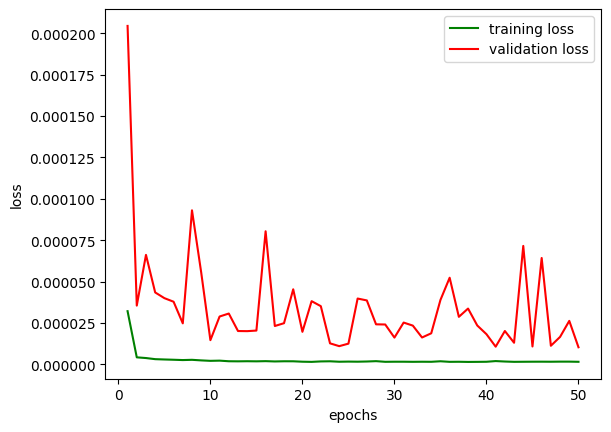

In [415]:
plot_training_history(fitted_optimized_lstm_50)

In [416]:
train_predict_optimized_lstm_50 = fitted_optimized_lstm_50.model.predict(X_train_50)
val_predict_optimized_lstm_50 = fitted_optimized_lstm_50.model.predict(X_val_50)

y_train_unscaled_50, train_predict_optimized_lstm_50_unscaled = print_error(y_train_50,train_predict_optimized_lstm_50,'Train')
y_val_unscaled_50, val_predict_optimized_lstm_50_unscaled = print_error(y_val_50,val_predict_optimized_lstm_50,'Validation')

36/36 [==============================] - 0s 5ms/step
Train root mean squared error (RMSE): 0.433
Validation root mean squared error (RMSE): 1.116


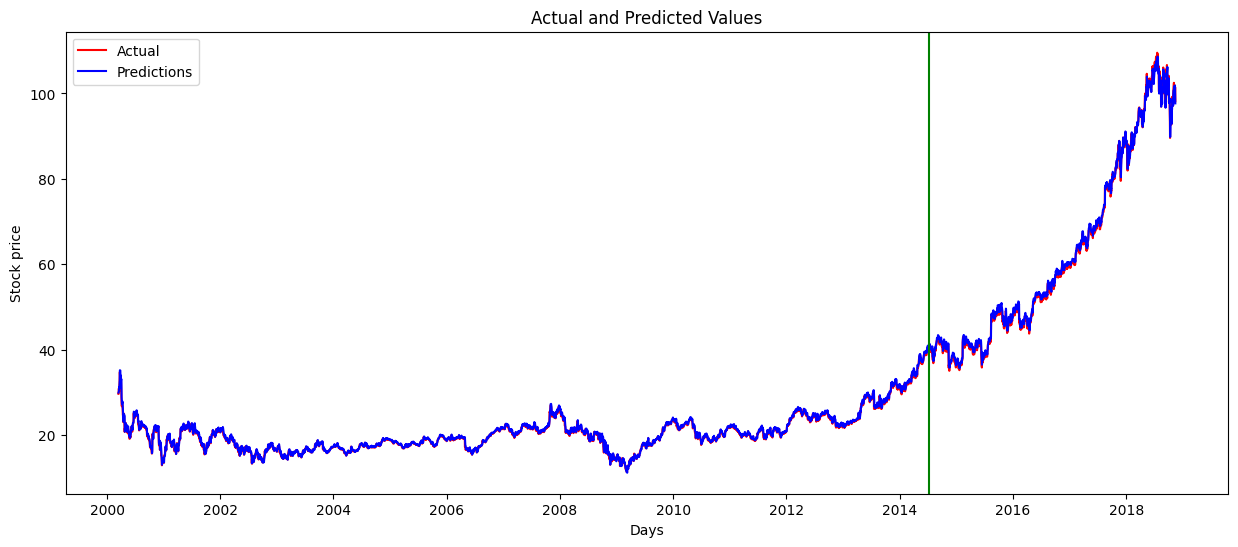

In [417]:
plot_result(y_train_unscaled_50, y_val_unscaled_50, train_predict_optimized_lstm_50_unscaled, val_predict_optimized_lstm_50_unscaled, TIME_STEP_50)

### GRU

In [254]:
def simple_GRU(hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape,activation=activation))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

In [419]:
n_hidden_units = 64
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [420]:
simple_gru = simple_GRU(n_hidden_units, n_dense_units,input_shape, activation='tanh')

fitted_simple_gru = simple_gru.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
112/112 [==============================] - 7s 20ms/step - loss: 3.8556e-05 - val_loss: 1.9453e-05
Epoch 2/50
112/112 [==============================] - 2s 13ms/step - loss: 2.9854e-06 - val_loss: 1.9541e-05
Epoch 3/50
112/112 [==============================] - 1s 13ms/step - loss: 2.9310e-06 - val_loss: 3.7544e-05
Epoch 4/50
112/112 [==============================] - 1s 13ms/step - loss: 2.8668e-06 - val_loss: 2.4228e-05
Epoch 5/50
112/112 [==============================] - 2s 14ms/step - loss: 2.5407e-06 - val_loss: 2.7878e-05
Epoch 6/50
112/112 [==============================] - 2s 18ms/step - loss: 2.8538e-06 - val_loss: 2.1198e-05
Epoch 7/50
112/112 [==============================] - 1s 13ms/step - loss: 2.6697e-06 - val_loss: 3.0279e-05
Epoch 8/50
112/112 [==============================] - 1s 13ms/step - loss: 2.4533e-06 - val_loss: 1.1981e-05
Epoch 9/50
112/112 [==============================] - 1s 13ms/step - loss: 2.2909e-06 - val_loss: 1.5137e-05
Epoch 10/50
112/112

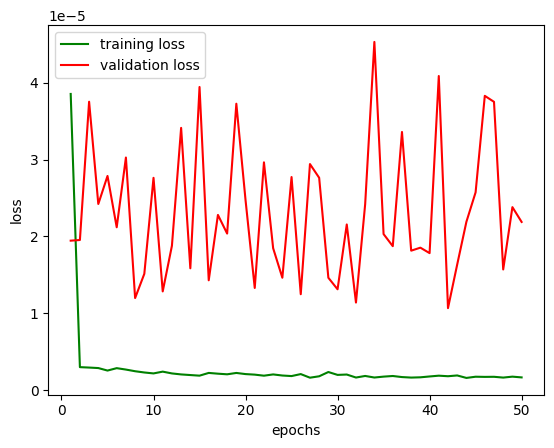

In [421]:
plot_training_history(fitted_simple_gru)

In [422]:
train_predict_gru = fitted_simple_gru.model.predict(X_train)
val_predict_gru = fitted_simple_gru.model.predict(X_val)

y_train_unscaled, train_predict_gru_unscaled = print_error(y_train,train_predict_gru,'Train')
y_val_unscaled, val_predict_gru_unscaled = print_error(y_val,val_predict_gru,'Validation')

37/37 [==============================] - 0s 5ms/step
Train root mean squared error (RMSE): 0.412
Validation root mean squared error (RMSE): 1.625


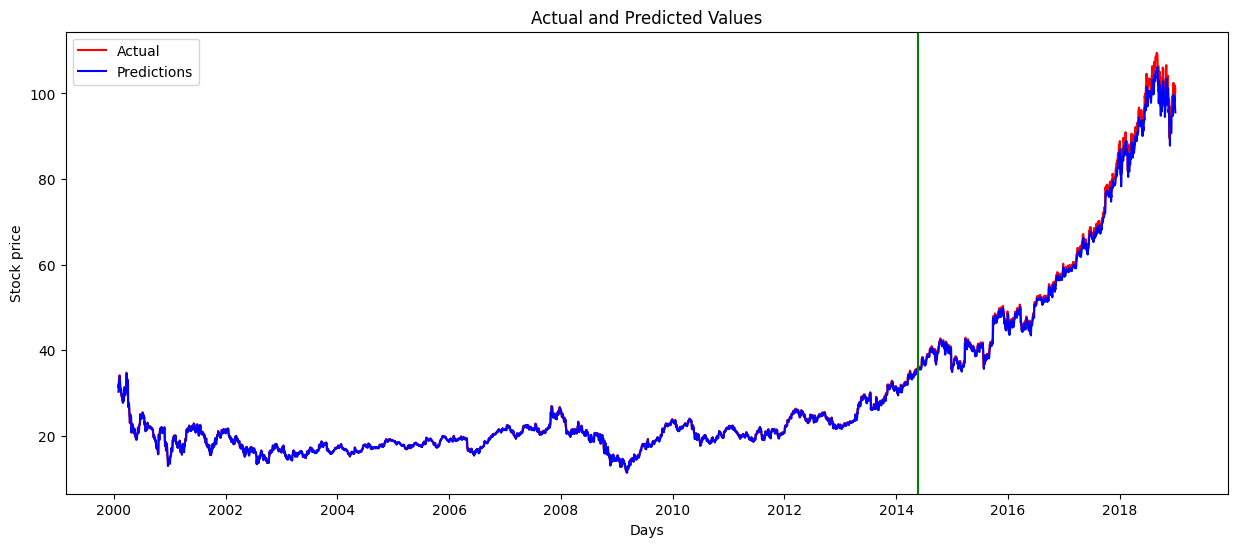

In [424]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_gru_unscaled, val_predict_gru_unscaled, TIME_STEP)

##### Add more layers

In [261]:
def GRU_1(hidden_units_list, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add(GRU(hidden_units_list[0], input_shape=input_shape, activation=activation, return_sequences=True))
    for i in range(1, len(hidden_units_list)):
        if i == len(hidden_units_list) - 1:
            model.add(GRU(hidden_units_list[i], activation=activation,
                      return_sequences=False))
        else:
            model.add(GRU(hidden_units_list[i], activation=activation,
                      return_sequences=True))

    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

In [263]:
n_hidden_units_list = [64, 64, 64]
n_dense_units = 1
input_shape = (TIME_STEP, 1)

In [426]:
gru_1 = GRU_1(n_hidden_units_list, n_dense_units, input_shape, activation='tanh')

fitted_gru_1 = gru_1.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
112/112 [==============================] - 19s 63ms/step - loss: 3.7830e-05 - val_loss: 1.7158e-05
Epoch 2/50
112/112 [==============================] - 4s 39ms/step - loss: 4.7988e-06 - val_loss: 1.9479e-05
Epoch 3/50
112/112 [==============================] - 5s 42ms/step - loss: 6.5715e-06 - val_loss: 2.1851e-05
Epoch 4/50
112/112 [==============================] - 4s 39ms/step - loss: 4.7755e-06 - val_loss: 1.8680e-04
Epoch 5/50
112/112 [==============================] - 5s 46ms/step - loss: 3.9890e-06 - val_loss: 1.7937e-05
Epoch 6/50
112/112 [==============================] - 5s 43ms/step - loss: 3.8137e-06 - val_loss: 6.1901e-05
Epoch 7/50
112/112 [==============================] - 5s 45ms/step - loss: 3.5046e-06 - val_loss: 4.0375e-05
Epoch 8/50
112/112 [==============================] - 5s 41ms/step - loss: 3.0217e-06 - val_loss: 1.5778e-05
Epoch 9/50
112/112 [==============================] - 4s 39ms/step - loss: 3.5652e-06 - val_loss: 1.4632e-05
Epoch 10/50
112/11

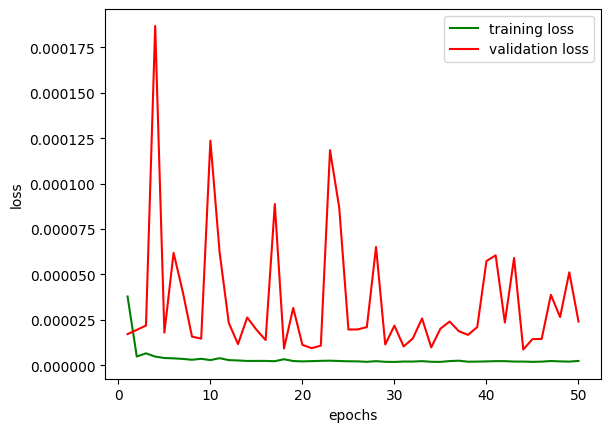

In [427]:
plot_training_history(fitted_gru_1)


In [428]:
train_predict_gru1 = fitted_gru_1.model.predict(X_train)
val_predict_gru1 = fitted_gru_1.model.predict(X_val)

37/37 [==============================] - 1s 14ms/step


In [429]:
y_train_unscaled, train_predict_gru1_unscaled = print_error(y_train,train_predict_gru1,'Train')
y_val_unscaled, val_predict_gru1_unscaled = print_error(y_val,val_predict_gru1,'Validation')

Train root mean squared error (RMSE): 0.495
Validation root mean squared error (RMSE): 1.706


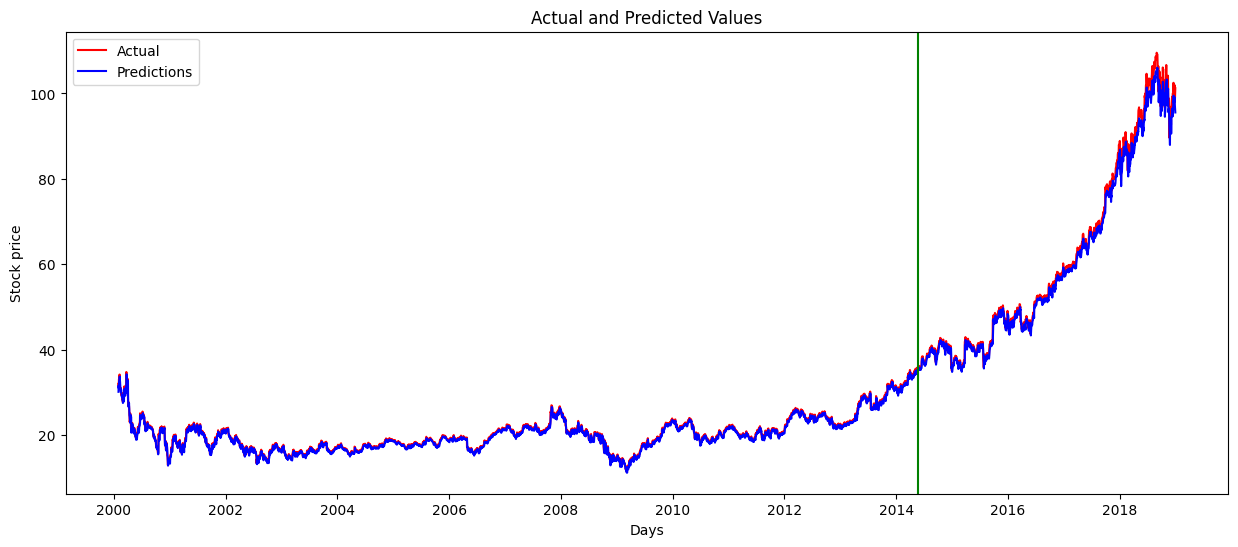

In [431]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_gru1_unscaled, val_predict_gru1_unscaled, TIME_STEP)

#### Optimizers and learning rate scheduling

In [277]:
# experiment with optimizer and learning rate.
def GRU_2(hidden_units, dense_units, input_shape, activation, optimizer="Adam"):
    model = Sequential()
    model.add(GRU(hidden_units, input_shape=input_shape, activation=activation))
    model.add(Dense(units=dense_units, activation=activation))

    optimizing_function = None
    if optimizer == "Adam":
        optimizing_function = keras.optimizers.Adam()
    elif optimizer == "RMSprop":
        optimizing_function = keras.optimizers.RMSprop()
    elif optimizer == "SGD":   
        optimizing_function = keras.optimizers.SGD() 

    model.compile(loss='mean_squared_error',optimizer=optimizing_function)
    return model

In [432]:
'''
Running the vanilla GRU model with RMSProp,Adam, SGD and 3 different types of learning rate
scheduling.
'''
n_hidden_units = 64
n_dense_units = 1
results_gru = []

optimizers = ["Adam", "RMSprop", "SGD"]

for optimizer in optimizers:
    for i, callback_decay_key in enumerate(callback_decay_keys):
        
        model = GRU_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer=optimizer)
        
        fitted_model = None
        
        if i == 0:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)
        else:
            fitted_model = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                                     batch_size=BATCH_SIZE, epochs=EPOCHS_NUM, callbacks=[callbacks_decay[i - 1]])

        predict = fitted_model.model.predict(X_val)
        y_pred = scaler.inverse_transform(predict)
        y_unscaled = scaler.inverse_transform(y_val.reshape(-1, 1))
        val_rmse = mean_squared_error(y_unscaled, y_pred, squared=False)

        results_gru.append((optimizer, callback_decay_keys[i], val_rmse))


Epoch 1/50
112/112 [==============================] - 68s 26ms/step - loss: 7.5078e-05 - val_loss: 1.7030e-05
Epoch 2/50
112/112 [==============================] - 2s 19ms/step - loss: 3.6280e-06 - val_loss: 4.4214e-05
Epoch 3/50
112/112 [==============================] - 1s 13ms/step - loss: 3.6323e-06 - val_loss: 5.1662e-05
Epoch 4/50
112/112 [==============================] - 3s 29ms/step - loss: 3.2451e-06 - val_loss: 5.0281e-05
Epoch 5/50
112/112 [==============================] - 2s 18ms/step - loss: 3.2615e-06 - val_loss: 4.8475e-05
Epoch 6/50
112/112 [==============================] - 2s 21ms/step - loss: 3.5186e-06 - val_loss: 3.9276e-05
Epoch 7/50
112/112 [==============================] - 2s 22ms/step - loss: 2.8654e-06 - val_loss: 3.3053e-05
Epoch 8/50
112/112 [==============================] - 1s 13ms/step - loss: 2.6769e-06 - val_loss: 5.0620e-05
Epoch 9/50
112/112 [==============================] - 3s 23ms/step - loss: 2.6498e-06 - val_loss: 1.5833e-05
Epoch 10/50
112/11

In [433]:
pd.DataFrame(results_gru, columns=["Optimizer", "Decay type", "Val RMSE"])

,Optimizer,Decay type,Val RMSE
0,Adam,constant,1.500570
1,Adam,step_decay,1.187432
2,Adam,exp_decay,1.469966
3,RMSprop,constant,4.218914
4,RMSprop,step_decay,2.825167
5,RMSprop,exp_decay,1.712440
6,SGD,constant,46.853225
7,SGD,step_decay,45.139183
8,SGD,exp_decay,41.456857


In [434]:
optimized_gru = GRU_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")


fitted_optimized_gru = optimized_gru.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, 
                                         epochs=EPOCHS_NUM, callbacks=[keras.callbacks.LearningRateScheduler(step_decay, verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
112/112 [==============================] - 7s 21ms/step - loss: 4.4057e-04 - val_loss: 0.0015 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
112/112 [==============================] - 2s 15ms/step - loss: 3.3138e-06 - val_loss: 3.0609e-05 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
112/112 [==============================] - 2s 15ms/step - loss: 2.4444e-06 - val_loss: 2.4938e-05 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
112/112 [==============================] - 2s 18ms/step - loss: 3.0171e-06 - val_loss: 6.9507e-05 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/50
112/112 [==============================] - 2s 15ms/step - loss: 2.4027e-06 - val_loss: 1.5846e-05 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/50
112/1

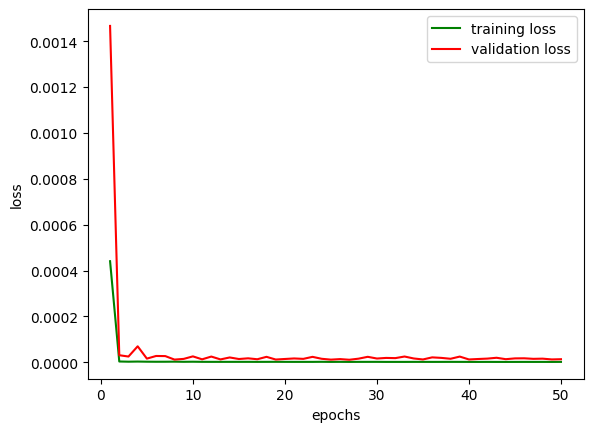

In [435]:
plot_training_history(fitted_optimized_gru)

In [436]:
train_predict_optimized_gru = fitted_optimized_gru.model.predict(X_train)
val_predict_optimized_gru = fitted_optimized_gru.model.predict(X_val)

37/37 [==============================] - 0s 6ms/step


In [437]:
y_train_unscaled, train_predict_optimized_gru_unscaled = print_error(y_train,train_predict_optimized_gru,'Train')
y_val_unscaled, val_predict_optimized_gru_unscaled = print_error(y_val,val_predict_optimized_gru,'Validation')

Train root mean squared error (RMSE): 0.509
Validation root mean squared error (RMSE): 1.265


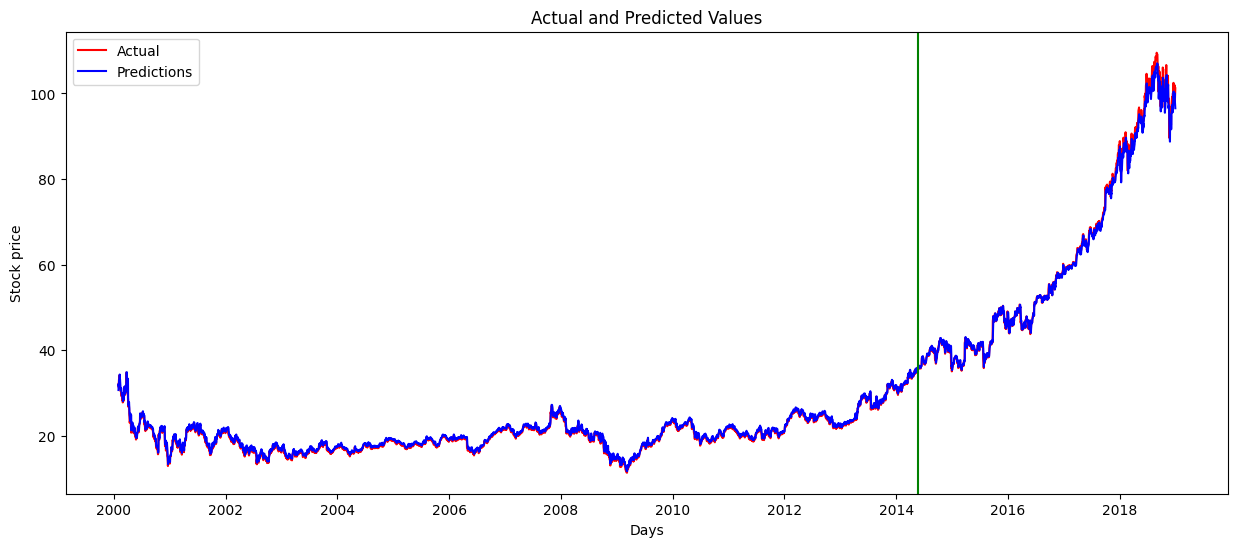

In [439]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_optimized_gru_unscaled, val_predict_optimized_gru_unscaled, TIME_STEP)

In [288]:
def GRU_bi(n_hidden_units, dense_units, input_shape, activation, lr=0.001):
    model = Sequential()
    model.add((GRU(n_hidden_units,return_sequences=True,input_shape = input_shape))) #64 lstm neuron block
    model.add(Bidirectional(GRU(n_hidden_units, return_sequences= False)))
    model.add(Dense(units=dense_units, activation=activation))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=lr))
    return model

In [440]:
gru_bi = GRU_bi(n_hidden_units, n_dense_units,input_shape, activation='tanh')


fitted_gru_bi = gru_bi.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, epochs=EPOCHS_NUM)

Epoch 1/50
112/112 [==============================] - 17s 52ms/step - loss: 6.1022e-05 - val_loss: 5.1084e-05
Epoch 2/50
112/112 [==============================] - 4s 34ms/step - loss: 5.2889e-06 - val_loss: 3.4553e-05
Epoch 3/50
112/112 [==============================] - 4s 37ms/step - loss: 4.2093e-06 - val_loss: 2.8484e-05
Epoch 4/50
112/112 [==============================] - 4s 33ms/step - loss: 4.8285e-06 - val_loss: 1.3951e-04
Epoch 5/50
112/112 [==============================] - 4s 37ms/step - loss: 3.3787e-06 - val_loss: 4.3090e-05
Epoch 6/50
112/112 [==============================] - 4s 37ms/step - loss: 3.3960e-06 - val_loss: 1.3552e-05
Epoch 7/50
112/112 [==============================] - 4s 36ms/step - loss: 3.0863e-06 - val_loss: 1.5071e-05
Epoch 8/50
112/112 [==============================] - 4s 38ms/step - loss: 3.1554e-06 - val_loss: 1.5278e-05
Epoch 9/50
112/112 [==============================] - 4s 33ms/step - loss: 3.1273e-06 - val_loss: 1.8487e-05
Epoch 10/50
112/11

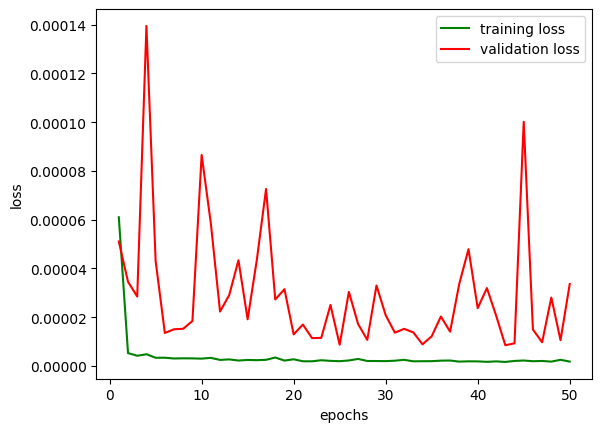

In [441]:
plot_training_history(fitted_gru_bi)

In [443]:
train_predict_gru_bi = fitted_gru_bi.model.predict(X_train)
val_predict_gru_bi = fitted_gru_bi.model.predict(X_val)

37/37 [==============================] - 0s 11ms/step


In [444]:
y_train_unscaled, train_predict_optimized_gru_bi_unscaled = print_error(y_train,train_predict_gru_bi,'Train')
y_val_unscaled, val_predict_optimized_gru_bi_unscaled = print_error(y_val,val_predict_gru_bi,'Validation')

Train root mean squared error (RMSE): 0.453
Validation root mean squared error (RMSE): 2.014


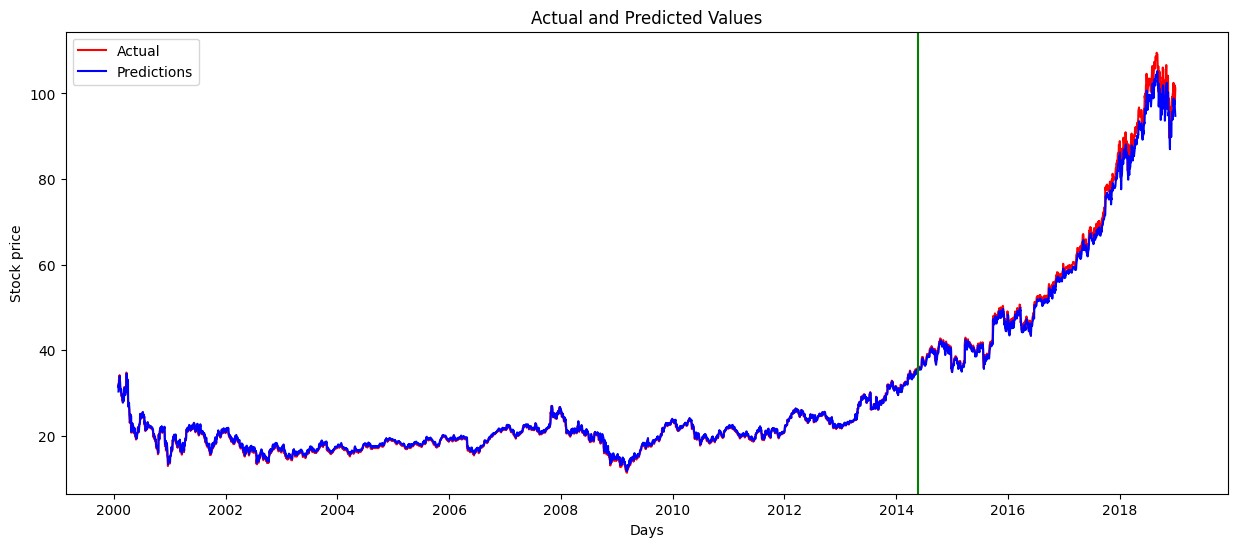

In [446]:
plot_result(y_train_unscaled, y_val_unscaled, train_predict_optimized_gru_bi_unscaled, val_predict_optimized_gru_bi_unscaled, TIME_STEP)

### Experiment with Window Size 10, 50

In [448]:
input_shape = (TIME_STEP_10, 1)
optimized_gru_10 = GRU_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")

fitted_optimized_gru_10 = optimized_gru_10.fit(X_train_10, y_train_10, validation_data=(X_val_10, y_val_10), batch_size=BATCH_SIZE, 
                                         epochs=EPOCHS_NUM, callbacks=[keras.callbacks.LearningRateScheduler(step_decay, verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
113/113 [==============================] - 6s 16ms/step - loss: 3.8768e-04 - val_loss: 2.5874e-04 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
113/113 [==============================] - 1s 10ms/step - loss: 2.7245e-06 - val_loss: 1.7624e-05 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
113/113 [==============================] - 1s 10ms/step - loss: 2.7343e-06 - val_loss: 1.8269e-05 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
113/113 [==============================] - 1s 10ms/step - loss: 2.6738e-06 - val_loss: 3.1828e-05 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/50
113/113 [==============================] - 1s 10ms/step - loss: 2.4238e-06 - val_loss: 2.2945e-05 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/50
1

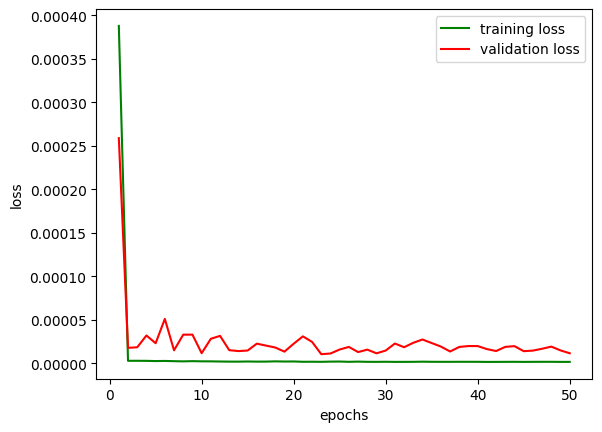

In [449]:
plot_training_history(fitted_optimized_gru_10)

In [450]:
train_predict_optimized_gru_10 = fitted_optimized_gru_10.model.predict(X_train_10)
val_predict_optimized_gru_10 = fitted_optimized_gru_10.model.predict(X_val_10)

y_train_unscaled_10, train_predict_optimized_gru_10_unscaled = print_error(y_train_10,train_predict_optimized_gru_10,'Train')
y_val_unscaled_10, val_predict_optimized_gru_10_unscaled = print_error(y_val_10,val_predict_optimized_gru_10,'Validation')

38/38 [==============================] - 0s 4ms/step
Train root mean squared error (RMSE): 0.444
Validation root mean squared error (RMSE): 1.172


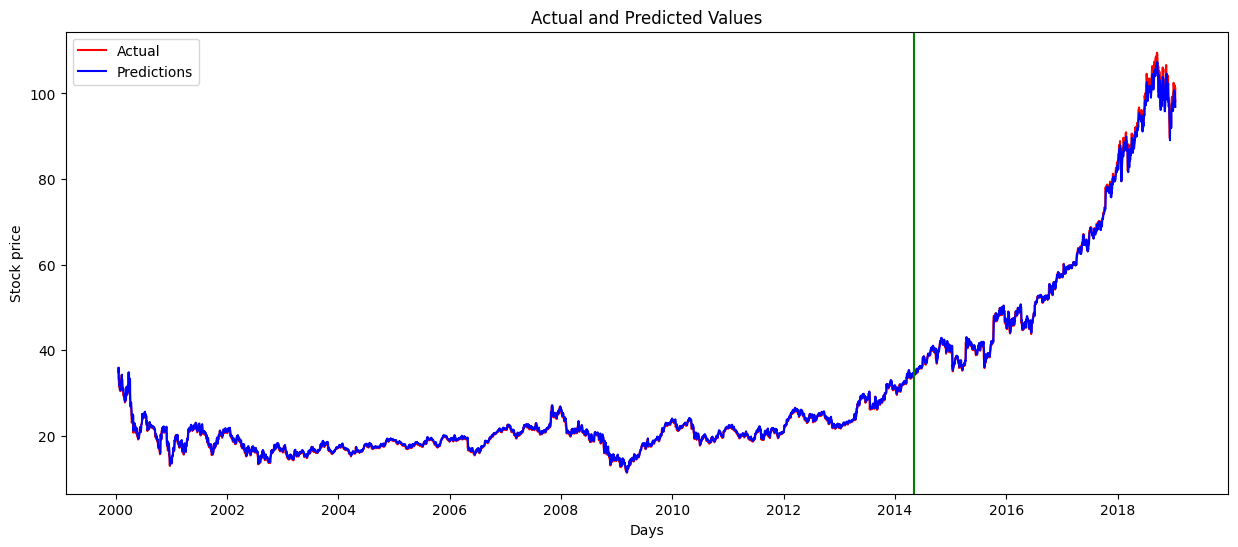

In [451]:
plot_result(y_train_unscaled_10, y_val_unscaled_10, train_predict_optimized_gru_10_unscaled, val_predict_optimized_gru_10_unscaled, TIME_STEP_10)

In [452]:
input_shape = (TIME_STEP_50, 1)
optimized_gru_50 = GRU_2(n_hidden_units, n_dense_units,input_shape, activation='tanh', optimizer="Adam")

fitted_optimized_gru_50 = optimized_gru.fit(X_train_50, y_train_50, validation_data=(X_val_50, y_val_50), batch_size=BATCH_SIZE, 
                                            epochs=EPOCHS_NUM, callbacks=[keras.callbacks.LearningRateScheduler(step_decay, verbose=1)])


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/50
111/111 [==============================] - 6s 33ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/50
111/111 [==============================] - 3s 28ms/step - loss: 3.3590e-06 - val_loss: 1.2175e-05 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/50
111/111 [==============================] - 3s 31ms/step - loss: 2.4478e-06 - val_loss: 1.1253e-05 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/50
111/111 [==============================] - 3s 28ms/step - loss: 2.1524e-06 - val_loss: 1.3422e-05 - lr: 0.0100

Epoch 5: LearningRateScheduler setting learning rate to 0.01.
Epoch 5/50
111/111 [==============================] - 4s 33ms/step - loss: 2.2354e-06 - val_loss: 2.0547e-05 - lr: 0.0100

Epoch 6: LearningRateScheduler setting learning rate to 0.01.
Epoch 6/50
111/111 [

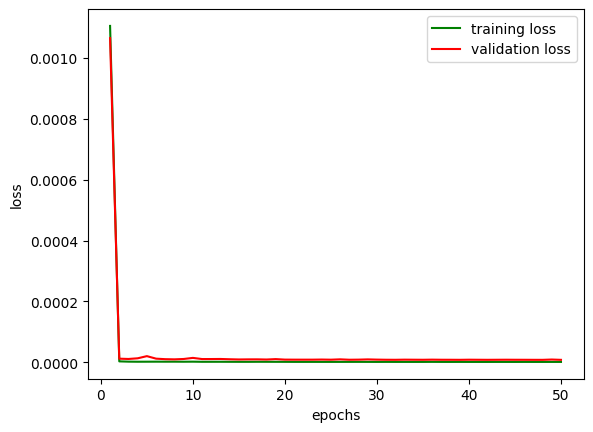

In [453]:
plot_training_history(fitted_optimized_gru_50)

In [454]:
train_predict_optimized_gru_50 = fitted_optimized_gru_50.model.predict(X_train_50)
val_predict_optimized_gru_50 = fitted_optimized_gru_50.model.predict(X_val_50)

y_train_unscaled_50, train_predict_optimized_gru_50_unscaled = print_error(y_train_50,train_predict_optimized_gru_50,'Train')
y_val_unscaled_50, val_predict_optimized_gru_50_unscaled = print_error(y_val_50,val_predict_optimized_gru_50,'Validation')

36/36 [==============================] - 0s 9ms/step
Train root mean squared error (RMSE): 0.423
Validation root mean squared error (RMSE): 1.005


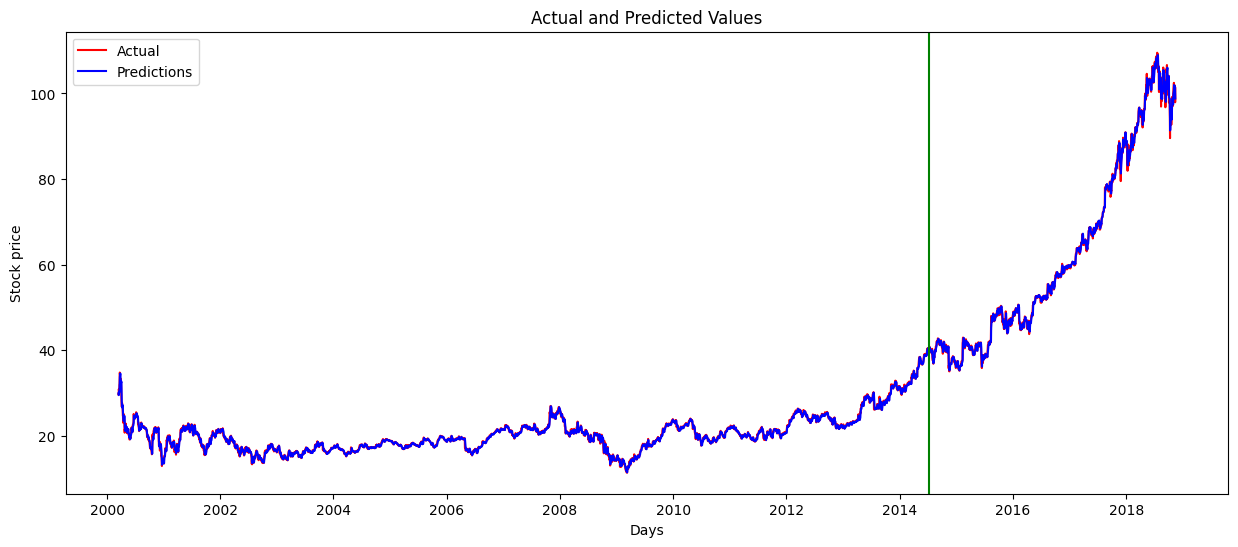

In [455]:
plot_result(y_train_unscaled_50, y_val_unscaled_50, train_predict_optimized_gru_50_unscaled, val_predict_optimized_gru_50_unscaled, TIME_STEP_50)

## On Test Data

In [469]:
test_predict_optimized_gru_50 = fitted_optimized_gru_50.model.predict(X_test_50)
y_test_unscaled_50, test_predict_optimized_gru_50_unscaled = print_error(y_test_50,test_predict_optimized_gru_50,'Test')

36/36 [==============================] - 1s 10ms/step
Test root mean squared error (RMSE): 38.405


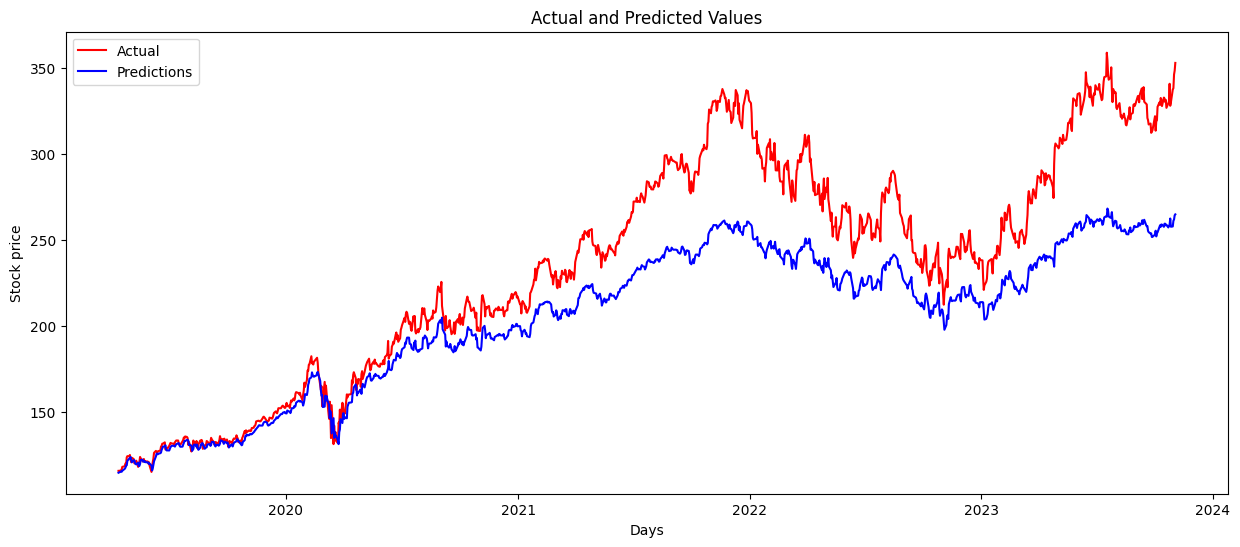

In [472]:
plot_test_result(y_test_unscaled_50, test_predict_optimized_gru_50_unscaled, TIME_STEP_50)

In [476]:
import sklearn
sklearn.metrics.mean_absolute_percentage_error(y_test_unscaled_50, test_predict_optimized_gru_50_unscaled)

0.08013520784820521

In [474]:
sklearn.metrics.r2_score(y_test_unscaled_50, test_predict_optimized_gru_50_unscaled)

0.6551786570607548